<a href="https://colab.research.google.com/github/ComputationalScienceLaboratory/control-pinns/blob/main/notebooks/ControlPINN_Predator_Prey_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-informed neural networks for PDE-constrained optimization and control
## Jostein Barry-Straume, Arash Sarshar, Andrey A. Popov, Adrian Sandu
## [Computational Science Lab](https://csl.cs.vt.edu/), Department of Computer Science, Virginia Tech

> Paper and Code can be found here: https://github.com/ComputationalScienceLaboratory/control-pinn

> This Google Colab notebook contains the code for training a Control PINN model on an open-loop optimal control problem for a two-dimensional predator prey problem

In [1]:
'''
Import the necessary libraries
'''
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Supress INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

## Decouple with Sparse Data

In [2]:
def y_ref(t, x1, x2):
  '''
  Reference solution of system states y1 and y2 (predator and prey respectively)
  :param t: time, needs to be a scalar
  :param x1: space, can be a vector
  :param x2: space, can be a vector
  :return: numpy array of the reference solution of the system states
    y1 and y2 (predator and prey respectively)
  '''
  Pi = np.pi
  predator_ref = t * np.multiply(np.sin(Pi * x1), np.sin(Pi * x2))
  prey_ref = (1.0-t) * np.multiply(np.sin(Pi * x1), np.sin(Pi * x2))
  temp = np.multiply(np.sin(2.0 * Pi * x1), np.sin(2.0 * Pi * x2))
  prey_ref += t * np.multiply(temp, temp)
  return predator_ref, prey_ref

Text(0.5, 1.0, 'Prey Diffusion')

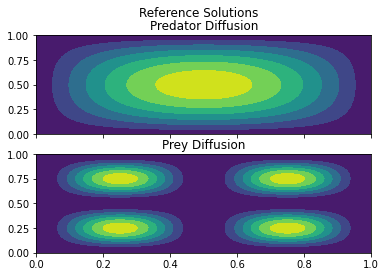

In [3]:
'''
Sanity check to see if the reference solutions were calculated properly
'''
x = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x, x)
temp1, temp2 = y_ref(1.0, X1, X2)
fig, axs = plt.subplots(2, sharex=True, sharey=True)
fig.suptitle('Reference Solutions')
axs[0].contourf(X1, X2, temp1)
axs[1].contourf(X1, X2, temp2)
axs[0].set_title('Predator Diffusion',fontsize=12)
axs[1].set_title('Prey Diffusion',fontsize=12)

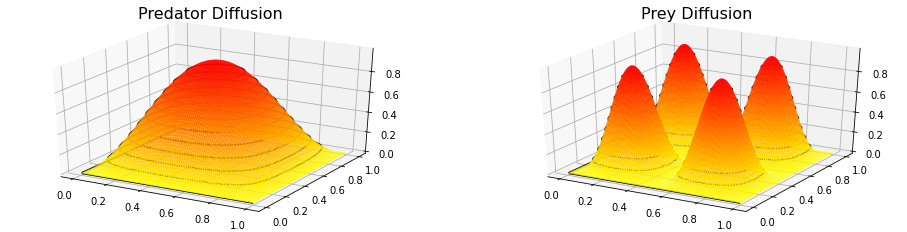

In [4]:
'''
Same plot as above just in 3D
'''
# Source:
# https://stackoverflow.com/questions/35445424/surface-and-3d-contour-in-matplotlib
# https://matplotlib.org/stable/gallery/mplot3d/subplot3d.html?highlight=subplot

# Create mesh grid
x = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x, x)
temp1, temp2 = y_ref(1, X1, X2)

fig = plt.figure(figsize=plt.figaspect(0.25))

# =============
# First subplot
# =============
# Set up the axes for the first plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X1, X2, temp1, cmap='autumn_r', lw=0.5, rstride=1, cstride=1)
ax1.contour(X1, X2, temp1, 10, lw=3, colors='k', linestyles='solid')
ax1.set_title('Predator Diffusion',fontsize=16)

# =============
# Second subplot
# =============
# Set up the axes for the second plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X1, X2, temp2, cmap='autumn_r', lw=0.5, rstride=1, cstride=1)
ax2.contour(X1, X2, temp2, 10, lw=3, colors='k', linestyles='solid')
ax2.set_title('Prey Diffusion',fontsize=16)
plt.show()

## Control PINN Model Class

In [5]:
class PINNModel(keras.Model):
  '''
  Initializes the model class object.
  :param num_unit: represents the neural density of each layer.
    The default value is 100 neurons.
  :param debug: is a binary toggle that prints to the console
    the values of each loss term in the custom loss function if set to zero,
    otherwise the model will train without said console output if set to one.
  '''
  def __init__(self, num_unit=100, debug=0):
    super(PINNModel, self).__init__()

    self.num_unit            = num_unit
    self.debug               = debug
    self.prey_birth_rate     = 1.0
    self.prey_death_rate     = 1.0
    self.prey_diffusion      = 1.0    
    self.predator_birth_rate = 1.0
    self.predator_death_rate = 1.0
    self.predator_diffusion  = 1.0
    self.u                   = None
    self.l                   = None
    self.y1                  = None
    self.y2                  = None
    self.out                 = None
    self.f1                  = None
    self.f2                  = None
    self.g                   = None
    self.dy1dx1dx1           = None
    self.dy1dx2dx2           = None
    self.dy2dx1dx1           = None
    self.dy2dx2dx2           = None
    self.dy1dt               = None
    self.dy2dt               = None
    self.dldt                = None
    self.df1dy1              = None
    self.df2dy2              = None
    self.df1du               = None
    self.dgdy1               = None
    self.dgdy2               = None
    self.dgdu                = None
    self.pdeLoss1            = None
    self.pdeLoss2            = None
    self.systemPushBack1     = None
    self.systemPushBack2     = None
    self.systemControl       = None

    # Layers of the neural network
    # https://github.com/tensorflow/tensorflow/issues/28799
    dim = (3,)
    dim = np.array(dim)
    act = 'elu'
    self.input_concat    = keras.layers.Concatenate(axis=1, name = 'input_concat')
    self.hidden_layer_1  = keras.layers.Dense(input_shape = dim, units=self.num_unit, name='hidden1', activation=act)
    self.hidden_layer_2  = keras.layers.Dense(units=self.num_unit, name='hidden2', activation=act)
    self.hidden_layer_3  = keras.layers.Dense(units=self.num_unit, name='hidden3', activation=act)
    self.hidden_layer_4  = keras.layers.Dense(units=self.num_unit, name='hidden4', activation=act)
    self.hidden_layer_5  = keras.layers.Dense(units=self.num_unit, name='hidden5', activation=act)
    self.hidden_layer_6  = keras.layers.Dense(units=self.num_unit, name='hidden6', activation=act)
    self.hidden_layer_7  = keras.layers.Dense(units=self.num_unit, name='hidden7', activation=act)
    self.hidden_layer_8  = keras.layers.Dense(units=self.num_unit, name='hidden8', activation=act)
    self.hidden_layer_9  = keras.layers.Dense(units=self.num_unit, name='hidden9', activation=act)
    self.hidden_layer_10 = keras.layers.Dense(units=self.num_unit, name='hidden10', activation=act)
    self.output_u_tilde  = keras.layers.Dense(1, name='output_u_tilde')
    self.output_l_tilde  = keras.layers.Dense(1, name='output_l_tilde')
    self.output_y1_tilde = keras.layers.Dense(1, name='output_y1_tilde')
    self.output_y2_tilde = keras.layers.Dense(1, name='output_y2_tilde')
    self.y_concat        = keras.layers.Concatenate(axis=1, name = 'y_concat')
    self.l_concat        = keras.layers.Concatenate(axis=1, name = 'l_concat')
    self.u_concat        = keras.layers.Concatenate(axis=1, name = 'u_concat')
    self.output_concat   = keras.layers.Concatenate(axis=1,  name = 'output_concat')

  def get_config(self):
    cfg = super().get_config()
    return cfg

  @classmethod
  def from_config(cls, config):
    return cls(**config)

  # Running the model
  def call(self, t, x1, x2):
    '''
    Train the model

    The parameter persistent=True is needed in order to calculate
    multiple gradients with different derivatives, which means the
    gradient tape needs to watch multiple tensors
    '''
    with tf.GradientTape(persistent=True) as tape, tf.GradientTape(persistent=True) as tape2:
      tape.watch(t)
      tape.watch(x1)
      tape.watch(x2)
      tx        = self.input_concat([t, x1, x2])
      h1        = self.hidden_layer_1(tx)
      h2        = self.hidden_layer_2(h1)
      h3        = self.hidden_layer_3(h2)
      h4        = self.hidden_layer_4(h3)
      h5        = self.hidden_layer_5(h4)
      y1        = self.output_y1_tilde(h5)
      y2        = self.output_y2_tilde(h5)
      y_input   = self.y_concat([y1, y2])
      u_input   = self.u_concat([y1, y2, h5])
      h6        = self.hidden_layer_6(u_input)
      h7        = self.hidden_layer_7(h6)
      h8        = self.hidden_layer_8(h7)
      u         = self.output_u_tilde(h8)
      l_input   = self.l_concat([y1, y2, u, h8])
      h9        = self.hidden_layer_9(l_input)
      h10       = self.hidden_layer_10(h9)
      l         = self.output_l_tilde(h10)
      out       = self.output_concat([y1, y2, l,  u])
      
      predator_ref, prey_ref = y_ref(t, x1, x2)

      g         = tf.multiply(0.5, tf.square(u))
      g         = tf.add(g, tf.square(tf.subtract(y2, prey_ref)))
      dy1dx1    = tape.gradient(y1, x1)
      dy2dx1    = tape.gradient(y2, x1)
      dy1dx1dx1 = tape.gradient(dy1dx1, x1)
      dy2dx1dx1 = tape.gradient(dy2dx1, x1)
      dy1dx2    = tape.gradient(y1, x2)
      dy2dx2    = tape.gradient(y2, x2)
      dy1dx2dx2 = tape.gradient(dy1dx2, x2)
      dy2dx2dx2 = tape.gradient(dy2dx2, x2)
      
      # Diffusion of predator and prey
      predator_diffusion = tf.multiply(self.predator_diffusion, dy1dx1dx1)
      predator_diffusion = tf.add(predator_diffusion, 
                                  tf.multiply(self.predator_diffusion, dy1dx2dx2))
      prey_diffusion = tf.multiply(self.prey_diffusion, dy2dx1dx1)
      prey_diffusion = tf.add(prey_diffusion,
                              tf.multiply(self.predator_diffusion, dy2dx2dx2))
      
      # Predator reaction
      predator_reaction = tf.multiply(-1.0 * self.predator_death_rate, y1)
      predator_reaction_intermediate = tf.multiply(self.predator_birth_rate, y1)
      predator_reaction_intermediate = tf.multiply(predator_reaction_intermediate, y2)
      predator_reaction = tf.add(predator_reaction, predator_reaction_intermediate)

      # Prey reaction
      prey_reaction = tf.multiply(1.0 * self.prey_birth_rate, y2)
      prey_reaction_intermediate = tf.multiply(-1.0 * self.prey_birth_rate, y1)
      prey_reaction_intermediate = tf.multiply(prey_reaction_intermediate, y2)
      prey_reaction = tf.add(prey_reaction, prey_reaction_intermediate)

      f1 = tf.add(predator_diffusion, predator_reaction)
      f1 = tf.add(f1, u)
      f2 = tf.add(prey_diffusion, prey_reaction)

      df1dy1  = tape.gradient(f1, y1)
      df1dy2  = tape.gradient(f1, y2)
      df2dy1  = tape.gradient(f2, y1)
      df2dy2  = tape.gradient(f2, y2)

      dy1dt   = tape.gradient(y1, t)
      dy2dt   = tape.gradient(y2, t)
      dldt  = tape.gradient(l, t)
 
      df1du  = tape.gradient(f1, u)
      dgdy1  = tape.gradient(g, y1)
      dgdy2  = tape.gradient(g, y2)
      dgdu  = tape.gradient(g, u)
      
      # Store various information in the model
      self.u = u
      self.l = l
      self.y1 = y1
      self.y2 = y2
      self.f1 = f1
      self.f2 = f2
      self.g = g
      # y1
      self.dy1dx1 = dy1dx1
      self.dy1dx2 = dy1dx2
      self.dy1dx1dx1 = dy1dx1dx1
      self.dy1dx2dx2 = dy1dx2dx2
      self.dy1dt = dy1dt
      # y2
      self.dy2dx1 = dy2dx1
      self.dy2dx2 = dy2dx2
      self.dy2dx1dx1 = dy2dx1dx1
      self.dy2dx2dx2 = dy2dx2dx2
      self.dy2dt = dy2dt
      self.dldt = dldt
      self.df1dy1 = df1dy1
      self.df2dy2 = df2dy2
      self.df1du = df1du
      self.dgdy1 = dgdy1
      self.dgdy2 = dgdy2
      self.dgdu = dgdu

    # PDE loss component of the extended loss function
    # Broken into 2 parts due to predator and prey
    pdeLoss1 = tf.subtract(dy1dt, f1)
    pdeLoss1 = tf.reduce_sum(tf.square(pdeLoss1))
    pdeLoss2 = tf.subtract(dy2dt, f2)
    pdeLoss2 = tf.reduce_sum(tf.square(pdeLoss2))
    self.add_loss(pdeLoss1)
    self.add_loss(pdeLoss2)
    self.pdeLoss1 = pdeLoss1
    self.pdeLoss2 = pdeLoss2

    # This component of the extended loss function represents the
    # System push back in response to the control
    systemPushBack1 = tf.add(dldt, tf.multiply(df1dy1, l))
    systemPushBack1 = tf.add(systemPushBack1, dgdy1)
    systemPushBack1 = tf.reduce_sum(tf.square(systemPushBack1))
    self.add_loss(systemPushBack1)
    self.systemPushBack1 = systemPushBack1

    systemPushBack2 = tf.multiply(df2dy2, l)
    systemPushBack2 = tf.add(systemPushBack2, dgdy2)
    systemPushBack2 = tf.reduce_sum(tf.square(systemPushBack2))
    self.add_loss(systemPushBack2)
    self.systemPushBack2 = systemPushBack2

    # This component of the extended loss function represents the
    # control (u) of the system (y2: prey)
    systemControl = tf.add(tf.multiply(df1du, l), dgdu)
    systemControl = tf.reduce_sum(tf.square(systemControl))
    self.add_loss(systemControl)
    self.systemControl = systemControl

    if (self.debug == 0):
      print('syspushback1: ', systemPushBack1)
      print('syspushback2: ', systemPushBack2)
      print('syscontrol: ', systemControl)
      print('pdeloss1: ', pdeLoss1)
      print('pdeloss2: ', pdeLoss2)
  
    return out

## Train on Two-Dimensional Predator Prey Data

In [6]:
'''
Explicitly define Mean Squared Error
to make sure that TensorFlow is calculating things properly
during our custom training loop.
'''
def real_MSE(y, yt):
  return tf.reduce_sum(tf.square(tf.subtract(y,yt)))

# Create model object and compile model
model = PINNModel()
model.compile(loss = keras.losses.MSE,
              metrics = keras.metrics.MSE)

# These are used in the custom training loop below
optimizer = tf.keras.optimizers.Adam(1e-2)
loss_fn = real_MSE

2,000 epochs with a learning rate of 1e-2

In [7]:
epochs           = 2000
steps            = 1
model.debug      = 1
innerIterations  = 1
t_initial        = 0.0
t_final          = 1.0
x1_left          = 0.0
x1_right         = 1.0
x2_bottom        = 0.0
x2_top           = 1.0
num_x_points     = 100
num_t_points     = num_x_points
batchSize        = num_x_points
w_pdeLoss        = 1e-1
w_systemPushback = 1e-1
w_systemControl  = 1e-1

lr = 1e-2
optimizer.learning_rate.assign(lr)

for epoch in range(epochs):
  # Iterate over the batches of a dataset.
  for step in range(steps):
    # Space batch points
    x1_sample = np.random.uniform(x1_left, x1_right, num_x_points).astype('float32')
    x2_sample = np.random.uniform(x2_bottom, x2_top, num_x_points).astype('float32')
    x1_sample_linspace = np.linspace(x1_left, x1_right, num=num_x_points).astype('float32')
    x2_sample_linspace = np.linspace(x2_bottom, x2_top, num=num_x_points).astype('float32')
    X1_batch_train, X2_batch_train = np.meshgrid(x1_sample, x2_sample)

    # Final time
    y1_final_time_train, y2_final_time_train = y_ref(t_final, X1_batch_train, X2_batch_train)
    y_final_time_train = tf.transpose(tf.convert_to_tensor([y1_final_time_train.flatten(),
                                                            y2_final_time_train.flatten()]))

    # Initial time
    y1_initial_time_train, y2_initial_time_train = y_ref(t_initial, X1_batch_train, X2_batch_train)
    y_initial_time_train = tf.transpose(tf.convert_to_tensor([y1_initial_time_train.flatten(),
                                                              y2_initial_time_train.flatten()]))

    # Time batch points
    t_batch_train = np.linspace(t_initial, t_final, num=num_t_points).astype('float32')
    
    with tf.GradientTape() as tape1:
      boundary_data_t  = np.asarray([t_batch_train, t_batch_train, t_batch_train,
                                    t_batch_train]).flatten().astype('float32')
      boundary_data_x1  = np.asarray([np.repeat(x1_left, num_t_points),
                                      np.repeat(x1_right, num_t_points),
                                      x1_sample_linspace, x1_sample_linspace]).flatten().astype('float32')
      boundary_data_x2  = np.asarray([x2_sample_linspace, x2_sample_linspace,
                                      np.repeat(x2_bottom, num_t_points),
                                      np.repeat(x2_top, num_t_points)]).flatten().astype('float32')
      boundary_data_t = tf.reshape(tf.constant(boundary_data_t), (-1,1))
      boundary_data_x1 = tf.reshape(tf.constant(boundary_data_x1), (-1,1))
      boundary_data_x2 = tf.reshape(tf.constant(boundary_data_x2), (-1,1))
      out = model(boundary_data_t, boundary_data_x1, boundary_data_x2)
      
      loss_value_at_bc = tf.reduce_sum(
          loss_fn(np.zeros((4 * num_t_points, 2), dtype='float32'), out[:,0:2]))
      
      # Final Time
      num_mesh_grid_points = num_x_points ** 2
      out = model(tf.reshape(tf.constant(np.repeat(t_final, num_mesh_grid_points)), (-1,1)),
                  tf.reshape(tf.constant(X1_batch_train), (-1,1)),
                  tf.reshape(tf.constant(X2_batch_train), (-1,1)))
      loss_value_at_final_time = tf.reduce_sum(loss_fn(y_final_time_train,
                                                       out[:,0:2]))

      # Initial Time
      out = model(tf.reshape(tf.constant(np.repeat(t_initial, num_mesh_grid_points)), (-1,1)),
                  tf.reshape(tf.constant(X1_batch_train), (-1,1)),
                  tf.reshape(tf.constant(X2_batch_train), (-1,1)))
      loss_value_at_initial_time = tf.reduce_sum(loss_fn(y_initial_time_train,
                                                       out[:,0:2]))

      # Sum each loss components      
      data_loss = loss_value_at_final_time\
                 + loss_value_at_initial_time\
                 + (loss_value_at_bc)
      
      # Add extra losses created during this forward pass:
      pinnloss = model.losses[0] * w_pdeLoss\
               + model.losses[1] * w_pdeLoss\
               + model.losses[2] * w_systemPushback\
               + model.losses[3] * w_systemPushback\
               + model.losses[4] * w_systemControl
      
      for i in range(innerIterations):
        # Subsample time
        sample_x1 = np.random.uniform(x1_left, x1_right, size=batchSize) 
        sample_x2 = np.random.uniform(x2_bottom, x2_top, size=batchSize) 
        sample_residual_points_X1, sample_residual_points_X2 = np.meshgrid(x1_sample, x2_sample)
        
        mesh_residual_batch_size = batchSize ** 2
        sampleResidualTimes  = np.random.uniform(t_initial, t_final, size=mesh_residual_batch_size).astype('float32')
        sample_residual_points_X1 = tf.reshape(tf.constant(sample_residual_points_X1.astype('float32')),(-1,1))
        sample_residual_points_X2 = tf.reshape(tf.constant(sample_residual_points_X2.astype('float32')),(-1,1))
        sampleResidualTimes = tf.reshape(tf.constant(sampleResidualTimes.astype('float32')),(-1,1))

        out = model(sampleResidualTimes, sample_residual_points_X1, sample_residual_points_X2)

        pinnloss += model.losses[0] * w_pdeLoss\
                  + model.losses[1] * w_pdeLoss\
                  + model.losses[2] * w_systemPushback\
                  + model.losses[3] * w_systemPushback\
                  + model.losses[4] * w_systemControl

      scaled_pinn_loss = ((pinnloss / innerIterations) / num_mesh_grid_points)
      total_loss = scaled_pinn_loss + data_loss

    # Apply gradient based on labeled data
    grads = tape1.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(
      f'Epoch {epoch + 1}, '
      f'Total Loss: {total_loss}, '
      f'Scaled PINN Loss: {scaled_pinn_loss}',
      f'Data Loss: {data_loss}')

Epoch 1, Total Loss: 9736.810546875, Scaled PINN Loss: 0.3693588376045227 Data Loss: 9736.44140625
Epoch 2, Total Loss: 201562.46875, Scaled PINN Loss: 16.30877685546875 Data Loss: 201546.15625
Epoch 3, Total Loss: 38217.05859375, Scaled PINN Loss: 8.331942558288574 Data Loss: 38208.7265625
Epoch 4, Total Loss: 7088.69580078125, Scaled PINN Loss: 4.605626583099365 Data Loss: 7084.09033203125
Epoch 5, Total Loss: 20267.85546875, Scaled PINN Loss: 3.983945369720459 Data Loss: 20263.87109375
Epoch 6, Total Loss: 7150.1279296875, Scaled PINN Loss: 1.1183196306228638 Data Loss: 7149.009765625
Epoch 7, Total Loss: 17998.306640625, Scaled PINN Loss: 0.5368605256080627 Data Loss: 17997.76953125
Epoch 8, Total Loss: 11830.0712890625, Scaled PINN Loss: 0.5731284022331238 Data Loss: 11829.498046875
Epoch 9, Total Loss: 3545.07080078125, Scaled PINN Loss: 2.868399143218994 Data Loss: 3542.202392578125
Epoch 10, Total Loss: 8874.6953125, Scaled PINN Loss: 3.1152687072753906 Data Loss: 8871.58007812

2,000 more epochs with a learning rate of 1e-3

In [8]:
epochs           = 2000
steps            = 1
model.debug      = 1
innerIterations  = 1
t_initial        = 0.0
t_final          = 1.0
x1_left          = 0.0
x1_right         = 1.0
x2_bottom        = 0.0
x2_top           = 1.0
num_x_points     = 100
num_t_points     = num_x_points
batchSize        = num_x_points
w_pdeLoss        = 1e-1
w_systemPushback = 1e-1
w_systemControl  = 1e-1

lr = 1e-3
optimizer.learning_rate.assign(lr)

for epoch in range(epochs):
  # Iterate over the batches of a dataset.
  for step in range(steps):
    # Space batch points
    x1_sample = np.random.uniform(x1_left, x1_right, num_x_points).astype('float32')
    x2_sample = np.random.uniform(x2_bottom, x2_top, num_x_points).astype('float32')
    x1_sample_linspace = np.linspace(x1_left, x1_right, num=num_x_points).astype('float32')
    x2_sample_linspace = np.linspace(x2_bottom, x2_top, num=num_x_points).astype('float32')
    X1_batch_train, X2_batch_train = np.meshgrid(x1_sample, x2_sample)

    # Final time
    y1_final_time_train, y2_final_time_train = y_ref(t_final, X1_batch_train, X2_batch_train)
    y_final_time_train = tf.transpose(tf.convert_to_tensor([y1_final_time_train.flatten(),
                                                            y2_final_time_train.flatten()]))

    # Initial time
    y1_initial_time_train, y2_initial_time_train = y_ref(t_initial, X1_batch_train, X2_batch_train)
    y_initial_time_train = tf.transpose(tf.convert_to_tensor([y1_initial_time_train.flatten(),
                                                              y2_initial_time_train.flatten()]))

    # Time batch points
    t_batch_train = np.linspace(t_initial, t_final, num=num_t_points).astype('float32')
    
    with tf.GradientTape() as tape1:
      boundary_data_t  = np.asarray([t_batch_train, t_batch_train, t_batch_train,
                                    t_batch_train]).flatten().astype('float32')
      boundary_data_x1  = np.asarray([np.repeat(x1_left, num_t_points),
                                      np.repeat(x1_right, num_t_points),
                                      x1_sample_linspace, x1_sample_linspace]).flatten().astype('float32')
      boundary_data_x2  = np.asarray([x2_sample_linspace, x2_sample_linspace,
                                      np.repeat(x2_bottom, num_t_points),
                                      np.repeat(x2_top, num_t_points)]).flatten().astype('float32')
      boundary_data_t = tf.reshape(tf.constant(boundary_data_t), (-1,1))
      boundary_data_x1 = tf.reshape(tf.constant(boundary_data_x1), (-1,1))
      boundary_data_x2 = tf.reshape(tf.constant(boundary_data_x2), (-1,1))
      out = model(boundary_data_t, boundary_data_x1, boundary_data_x2)
      
      loss_value_at_bc = tf.reduce_sum(
          loss_fn(np.zeros((4 * num_t_points, 2), dtype='float32'), out[:,0:2]))
      
      # Final Time
      num_mesh_grid_points = num_x_points ** 2
      out = model(tf.reshape(tf.constant(np.repeat(t_final, num_mesh_grid_points)), (-1,1)),
                  tf.reshape(tf.constant(X1_batch_train), (-1,1)),
                  tf.reshape(tf.constant(X2_batch_train), (-1,1)))
      loss_value_at_final_time = tf.reduce_sum(loss_fn(y_final_time_train,
                                                       out[:,0:2]))

      # Initial Time
      out = model(tf.reshape(tf.constant(np.repeat(t_initial, num_mesh_grid_points)), (-1,1)),
                  tf.reshape(tf.constant(X1_batch_train), (-1,1)),
                  tf.reshape(tf.constant(X2_batch_train), (-1,1)))
      loss_value_at_initial_time = tf.reduce_sum(loss_fn(y_initial_time_train,
                                                       out[:,0:2]))

      # Sum each loss components      
      data_loss = loss_value_at_final_time\
                 + loss_value_at_initial_time\
                 + (loss_value_at_bc)
      
      # Add extra losses created during this forward pass:
      pinnloss = model.losses[0] * w_pdeLoss\
               + model.losses[1] * w_pdeLoss\
               + model.losses[2] * w_systemPushback\
               + model.losses[3] * w_systemPushback\
               + model.losses[4] * w_systemControl
      
      for i in range(innerIterations):
        # Subsample time
        sample_x1 = np.random.uniform(x1_left, x1_right, size=batchSize) 
        sample_x2 = np.random.uniform(x2_bottom, x2_top, size=batchSize) 
        sample_residual_points_X1, sample_residual_points_X2 = np.meshgrid(x1_sample, x2_sample)
        
        mesh_residual_batch_size = batchSize ** 2
        sampleResidualTimes  = np.random.uniform(t_initial, t_final, size=mesh_residual_batch_size).astype('float32')
        sample_residual_points_X1 = tf.reshape(tf.constant(sample_residual_points_X1.astype('float32')),(-1,1))
        sample_residual_points_X2 = tf.reshape(tf.constant(sample_residual_points_X2.astype('float32')),(-1,1))
        sampleResidualTimes = tf.reshape(tf.constant(sampleResidualTimes.astype('float32')),(-1,1))

        out = model(sampleResidualTimes, sample_residual_points_X1, sample_residual_points_X2)

        pinnloss += model.losses[0] * w_pdeLoss\
                  + model.losses[1] * w_pdeLoss\
                  + model.losses[2] * w_systemPushback\
                  + model.losses[3] * w_systemPushback\
                  + model.losses[4] * w_systemControl

      scaled_pinn_loss = ((pinnloss / innerIterations) / num_mesh_grid_points)
      total_loss = scaled_pinn_loss + data_loss

    # Apply gradient based on labeled data
    grads = tape1.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(
      f'Epoch {epoch + 1}, '
      f'Total Loss: {total_loss}, '
      f'Scaled PINN Loss: {scaled_pinn_loss}',
      f'Data Loss: {data_loss}')

Epoch 1, Total Loss: 97.38341522216797, Scaled PINN Loss: 31.270668029785156 Data Loss: 66.11274719238281
Epoch 2, Total Loss: 73.37738037109375, Scaled PINN Loss: 25.337175369262695 Data Loss: 48.04020690917969
Epoch 3, Total Loss: 60.182952880859375, Scaled PINN Loss: 27.77461814880371 Data Loss: 32.40833282470703
Epoch 4, Total Loss: 47.63965606689453, Scaled PINN Loss: 31.3787899017334 Data Loss: 16.2608642578125
Epoch 5, Total Loss: 42.032196044921875, Scaled PINN Loss: 29.018815994262695 Data Loss: 13.013379096984863
Epoch 6, Total Loss: 48.93353271484375, Scaled PINN Loss: 30.333637237548828 Data Loss: 18.59989356994629
Epoch 7, Total Loss: 60.82689666748047, Scaled PINN Loss: 34.42583465576172 Data Loss: 26.40106201171875
Epoch 8, Total Loss: 56.197486877441406, Scaled PINN Loss: 32.61690902709961 Data Loss: 23.580577850341797
Epoch 9, Total Loss: 50.992034912109375, Scaled PINN Loss: 32.38528060913086 Data Loss: 18.606754302978516
Epoch 10, Total Loss: 48.15402603149414, Scale

Checking the sampling of boundary points

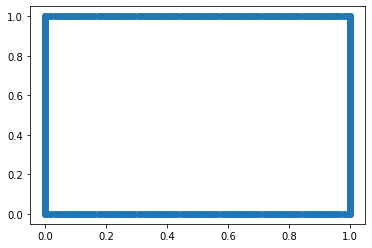

In [9]:
plt.scatter(boundary_data_x1, boundary_data_x2)

## Visualization of Results

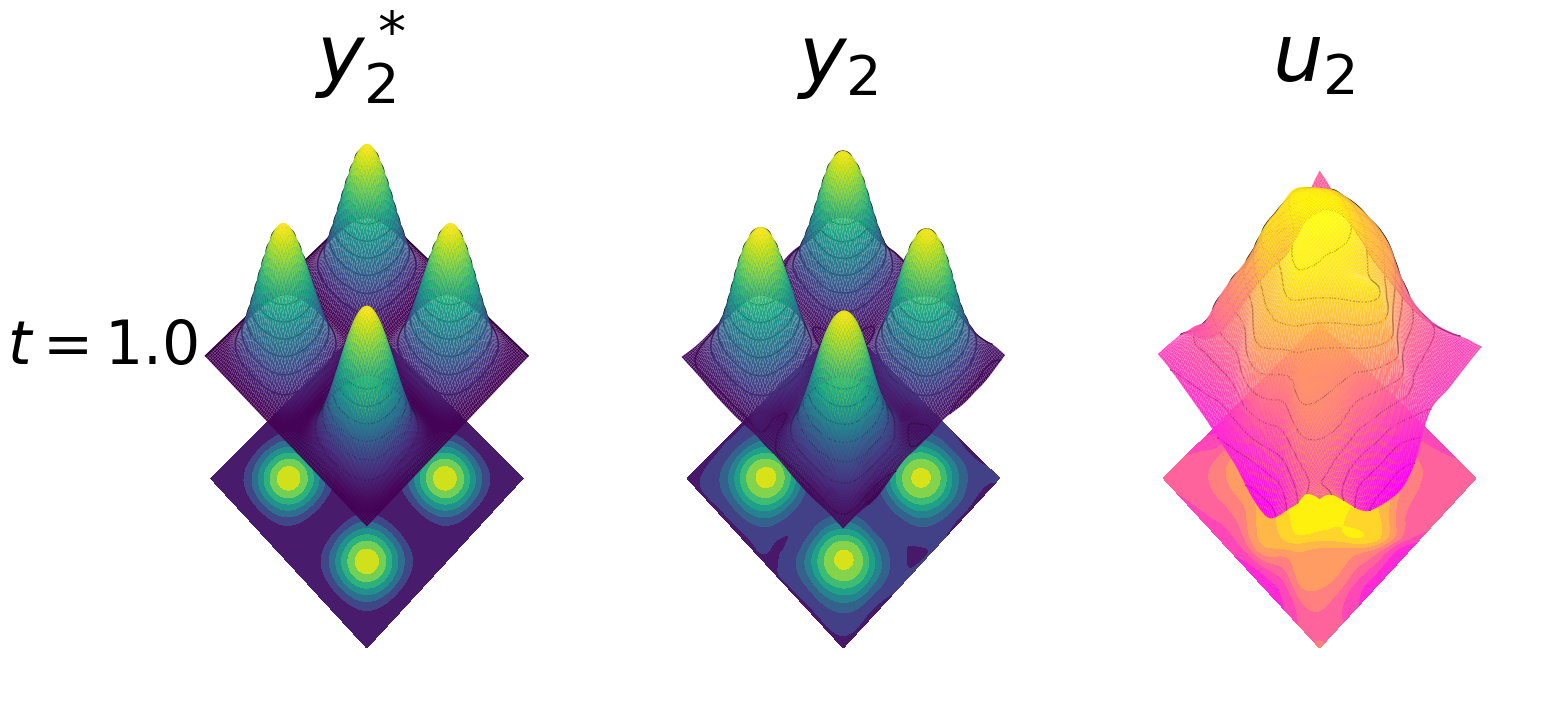

In [ ]:
from matplotlib import cm

num_plot_points = 100
x = np.linspace(0, 1, num_plot_points)
X1_plot, X2_plot = np.meshgrid(x, x)
X1_plot = X1_plot.astype('float32')
X2_plot = X2_plot.astype('float32')
timespans = [1.0] # Just plot the final time
num_time_plots = len(timespans)
titles = ['$y_1^*$', '$y_1$', '$y_2^*$', '$y_2$', '$u_2$']

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(20,10))
fig.text(-0.01, .5, '$t=1.0$', ha='center',va='center', size=60)
j = 0

# Model output: y1, y2, l,  u
Y1, Y2 = y_ref(timespans[j], X1_plot, X2_plot)
pred = model(tf.reshape(tf.constant(np.repeat(timespans[j], num_plot_points ** 2)),(-1,1)),
          tf.reshape(tf.constant(X1_plot.flatten()), (-1,1)),
          tf.reshape(tf.constant(X2_plot.flatten()), (-1,1)))

# Prey Reference
ax3 = fig.add_subplot(1,3,1, projection='3d')
ax3.set_zlim(-1,1)
ax3.set_title('{}'.format(titles[2]),fontsize=80)
ax3.plot_surface(X1_plot, X2_plot, Y2, cmap='viridis', lw=3, rstride=1, cstride=1)
ax3.contour(X1_plot, X2_plot, Y2, 10, lw=3, colors='k', linestyles='solid')
ax3.contourf(X1_plot, X2_plot, Y2, zdir='z', offset=-1, cmap='viridis')
ax3.axis('off')
ax3.view_init(45,45)

# Prey Prediction
ax4 = fig.add_subplot(1,3,2, projection='3d')
ax4.set_zlim(-1,1)
ax4.set_title('{}'.format(titles[3]),fontsize=80)
prey_prediction = pred[:,1].numpy().reshape(num_plot_points, num_plot_points)
ax4.plot_surface(X1_plot, X2_plot, prey_prediction, cmap='viridis', lw=3, rstride=1, cstride=1)
ax4.contour(X1_plot, X2_plot, prey_prediction, 10, lw=3, colors='k', linestyles='solid')
ax4.contourf(X1_plot, X2_plot, prey_prediction, zdir='z', offset=-1, cmap='viridis')
ax4.axis('off')
ax4.view_init(45,45)

# Control
ax6 = fig.add_subplot(1,3,3, projection='3d')
ax6.set_zlim(-20,20)
ax6.set_title('{}'.format(titles[4]),fontsize=80)
control = pred[:,3].numpy().reshape(num_plot_points, num_plot_points)
ax6.plot_surface(X1_plot, X2_plot, control, cmap='spring', lw=3, rstride=1, cstride=1)
ax6.contour(X1_plot, X2_plot, control, 10, lw=5, colors='k', linestyles='solid')
ax6.contourf(X1_plot, X2_plot, control, zdir='z', offset=-20, cmap='spring')
ax6.axis('off')
ax6.view_init(45,45)

fig.tight_layout()
plt.show()

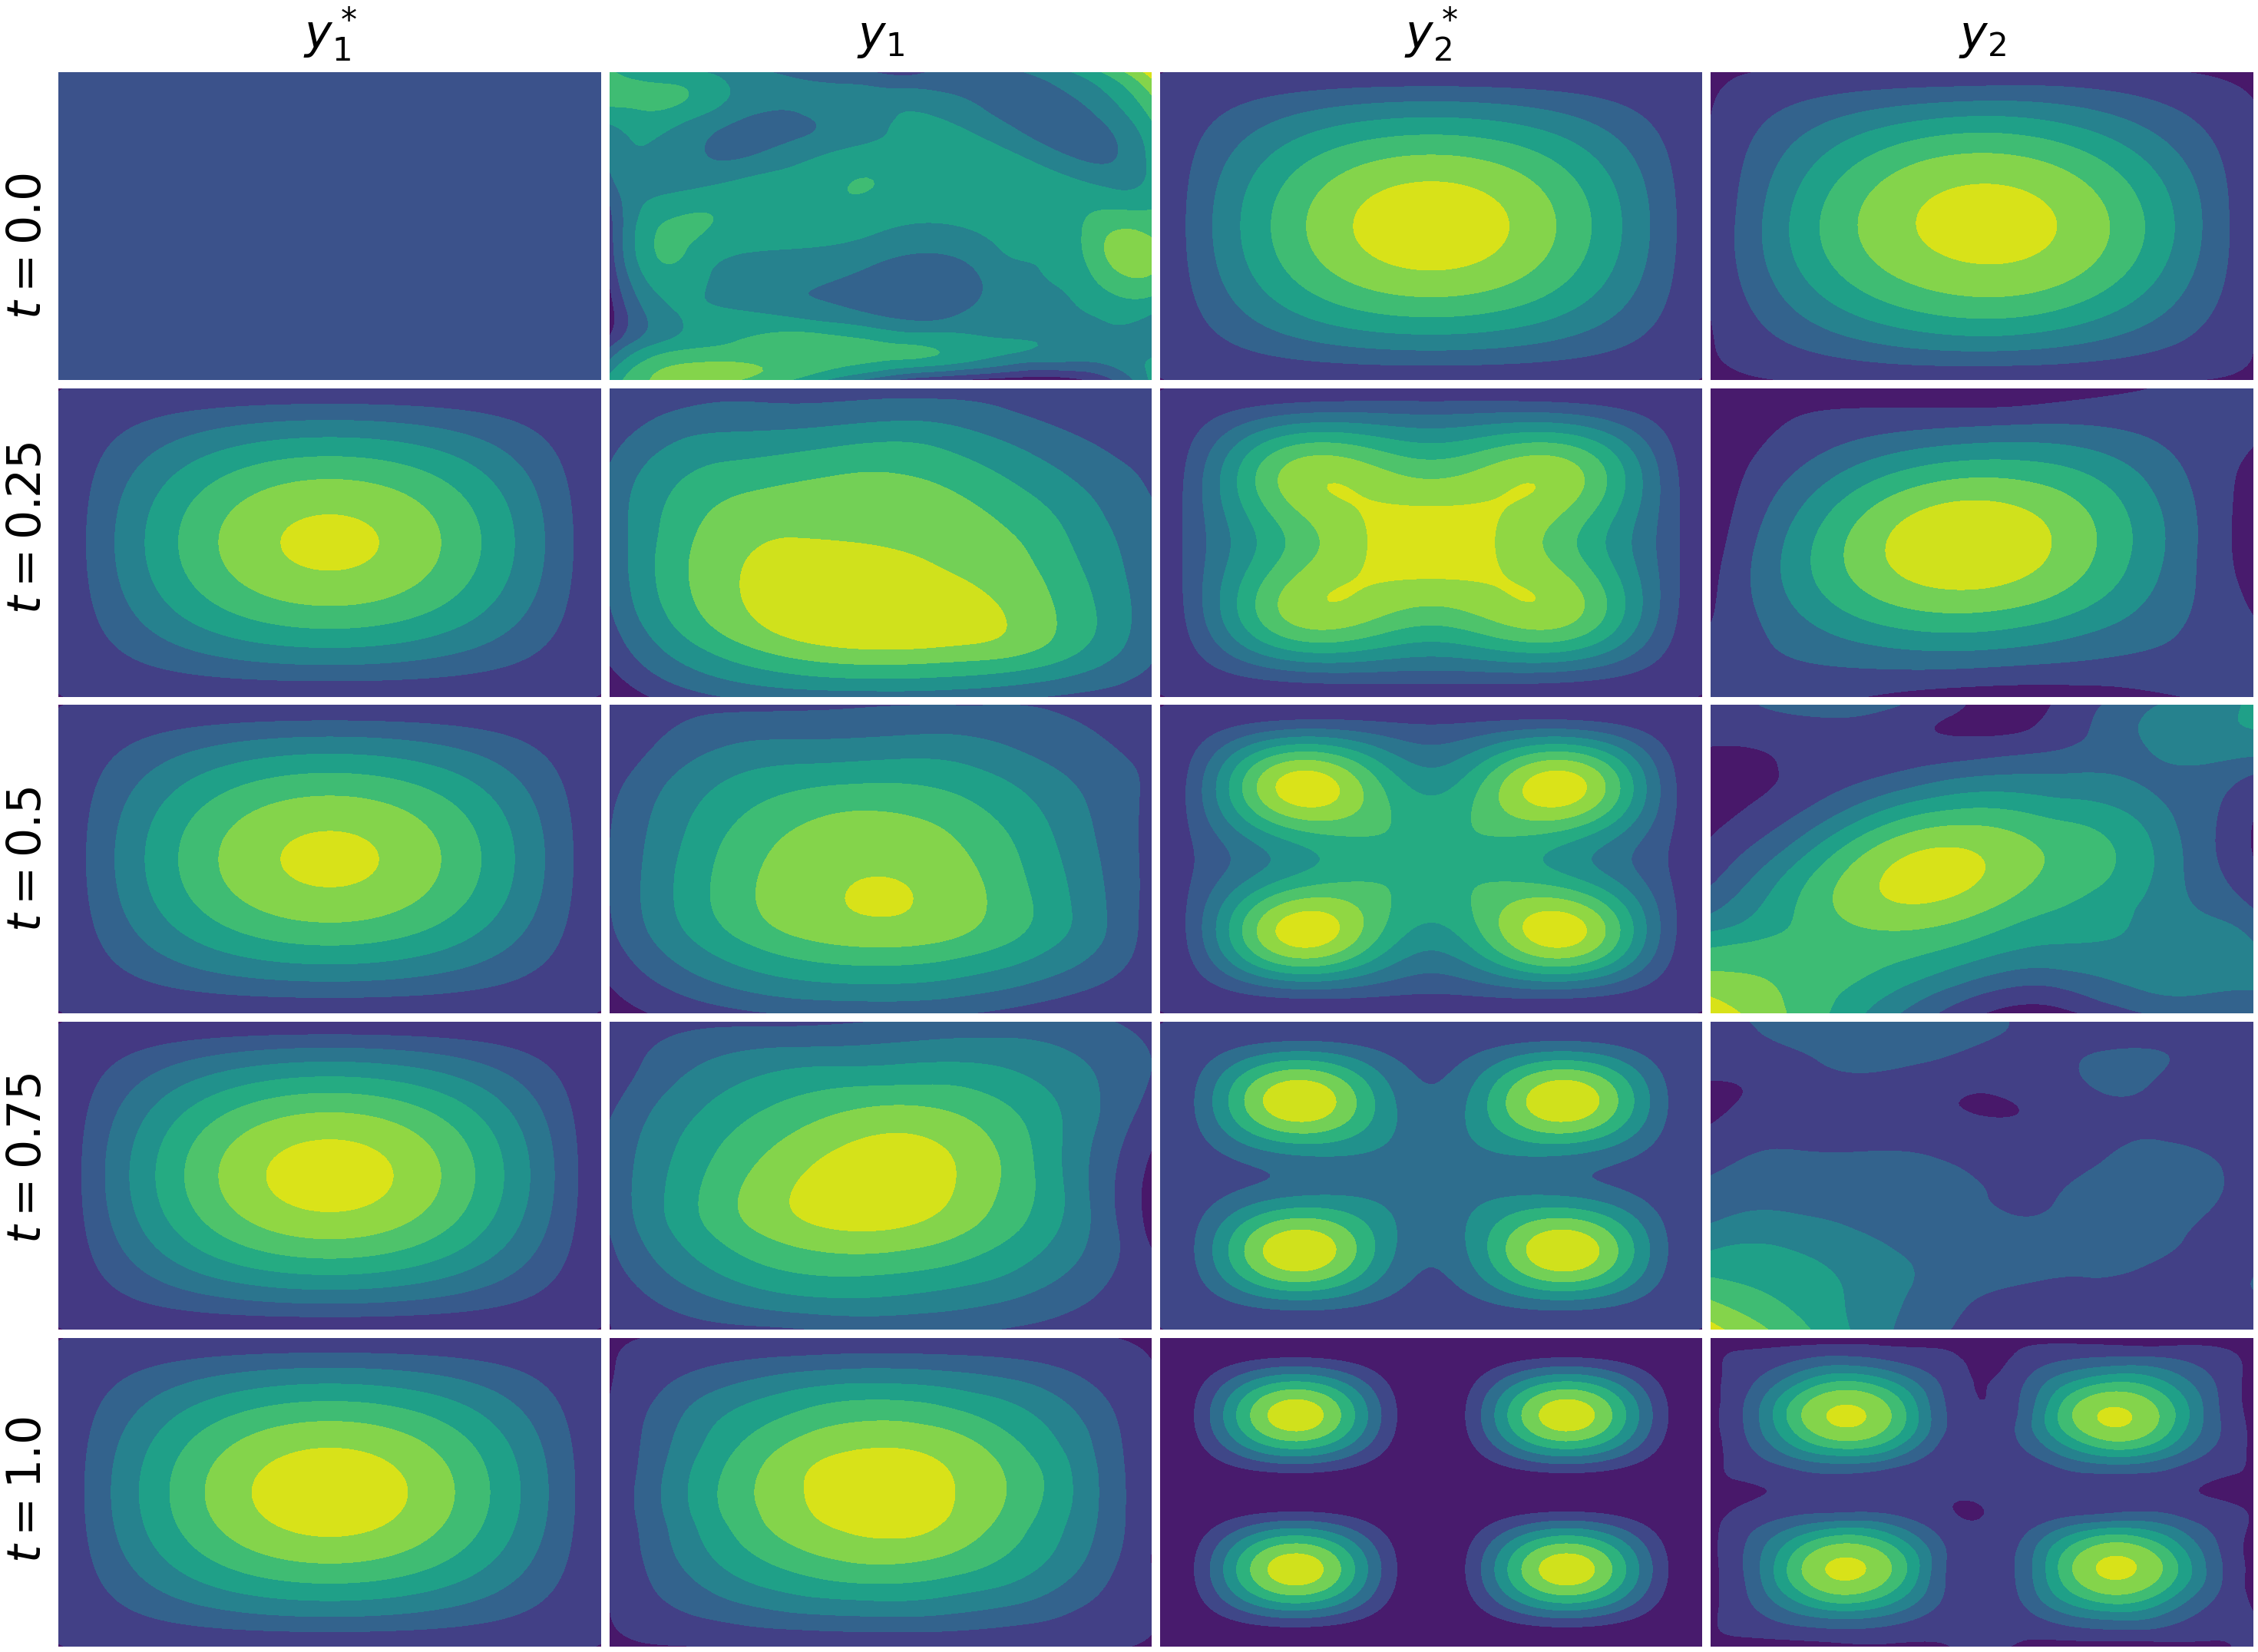

In [41]:
num_plot_points = 100
x = np.linspace(0, 1, num_plot_points)
X1_plot, X2_plot = np.meshgrid(x, x)
X1_plot = X1_plot.astype('float32')
X2_plot = X2_plot.astype('float32')

timespan = 0.0
timespans = [0.0, 0.25, 0.5, 0.75, 1.0]
num_time_plots = len(timespans)
titles = ['$y_1^*$', '$y_1$', '$y_2^*$', '$y_2$']

fig, axs = plt.subplots(len(timespans), 4, sharex=True, sharey=True, figsize=(40,30))
fig.text(-0.010, .85, '$t=0.0$', ha='center',va='center', size=60, rotation='vertical')
fig.text(-0.010, .68, '$t=0.25$', ha='center',va='center', size=60, rotation='vertical')
fig.text(-0.010, .48, '$t=0.5$', ha='center',va='center', size=60, rotation='vertical')
fig.text(-0.010, .3, '$t=0.75$', ha='center',va='center', size=60, rotation='vertical')
fig.text(-0.010, .1, '$t=1.0$', ha='center',va='center', size=60, rotation='vertical')
for i in range(num_time_plots):
  if (i < 5):
    for j in range(4):
      axs[0,j].set_title('{}'.format(titles[j], timespans[i]),fontsize=60, pad=30)
  Y1, Y2 = y_ref(timespans[i], X1_plot, X2_plot)
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[i], num_plot_points ** 2)),(-1,1)),
            tf.reshape(tf.constant(X1_plot.flatten()), (-1,1)),
            tf.reshape(tf.constant(X2_plot.flatten()), (-1,1)))
  axs[i,0].contourf(X1_plot, X2_plot, Y1, label='Ref_Predator')
  axs[i,1].contourf(X1_plot, X2_plot, pred[:,0].numpy().reshape(num_plot_points, num_plot_points), label='Predator')
  axs[i,2].contourf(X1_plot, X2_plot, Y2, label='Ref_Prey')
  axs[i,3].contourf(X1_plot, X2_plot, pred[:,1].numpy().reshape(num_plot_points, num_plot_points), label='Prey')
  axs[i,0].axis('off')
  axs[i,1].axis('off')
  axs[i,2].axis('off')
  axs[i,3].axis('off')
plt.tight_layout()
plt.show()

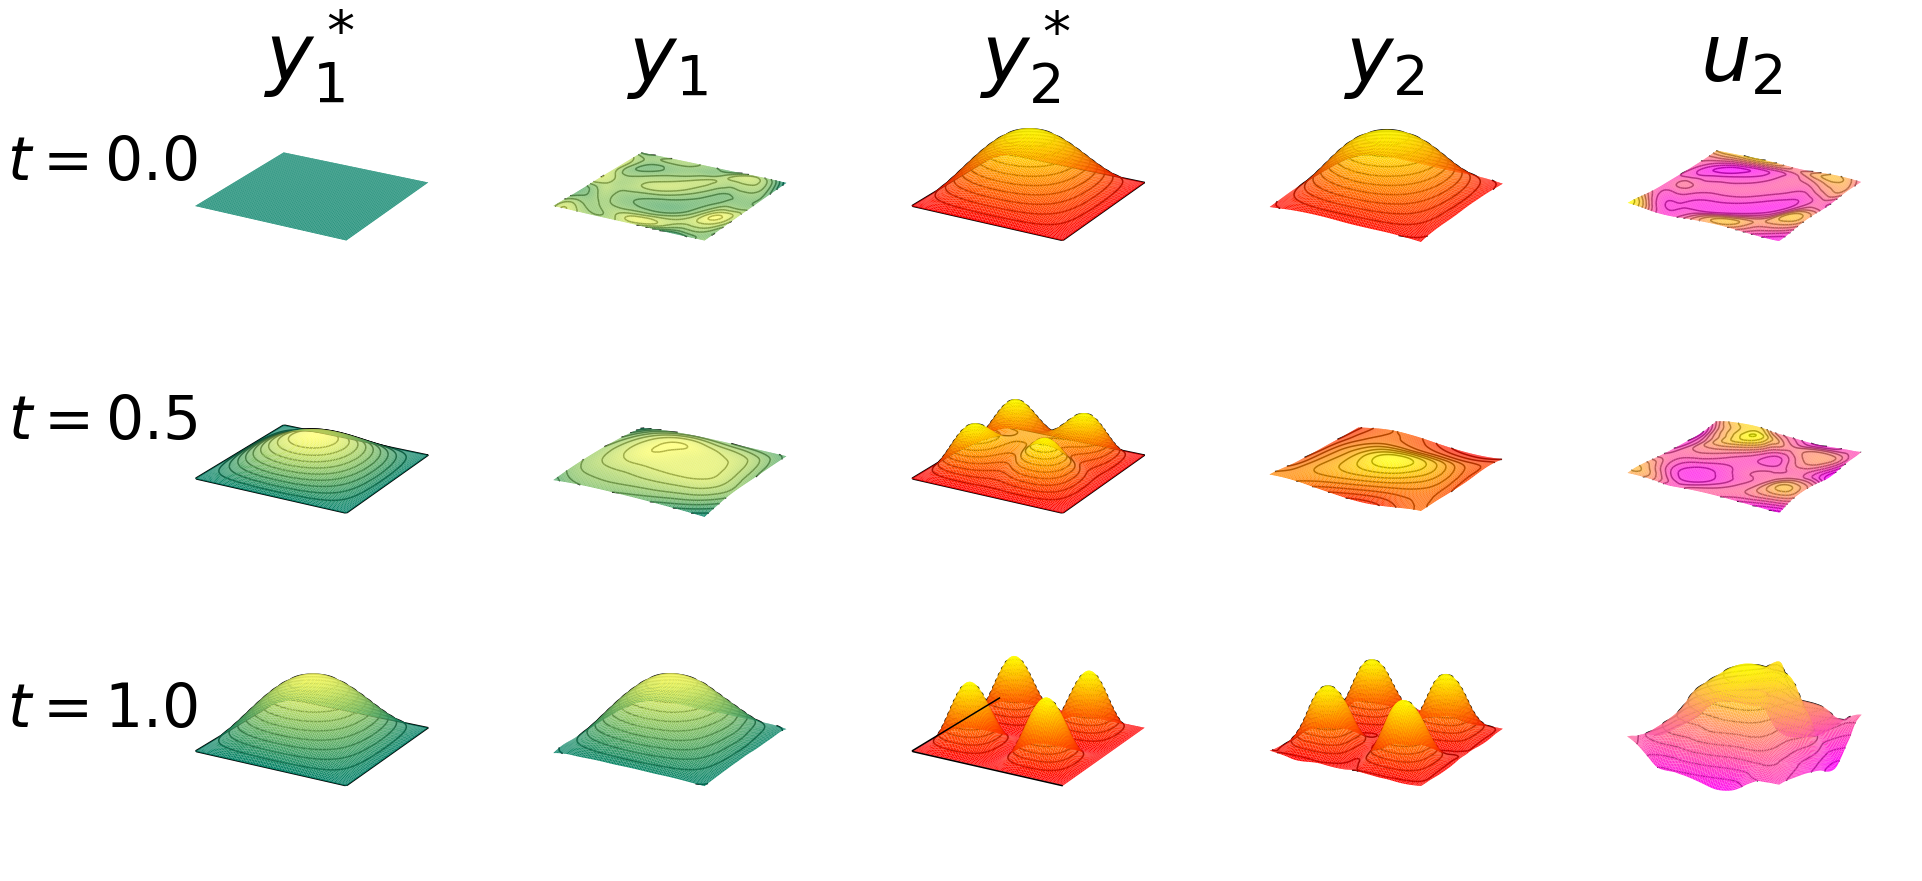

In [ ]:
from matplotlib import cm

num_plot_points = 100
x = np.linspace(0, 1, num_plot_points)
X1_plot, X2_plot = np.meshgrid(x, x)
X1_plot = X1_plot.astype('float32')
X2_plot = X2_plot.astype('float32')

timespans = [0.0, 0.5, 1.0]
num_time_plots = len(timespans)
titles = ['$y_1^*$', '$y_1$', '$y_2^*$', '$y_2$', '$u_2$']

fig = plt.figure(figsize=(30,20))
fig.text(-0.010, .88, '$t=0.0$', ha='center',va='center', size=60)
fig.text(-0.010, .7, '$t=0.5$', ha='center',va='center', size=60)
fig.text(-0.010, .5, '$t=1.0$', ha='center',va='center', size=60)
j = 0

# Model output: y1, y2, l,  u
for i in range(1,16,6):
  Y1, Y2 = y_ref(timespans[j], X1_plot, X2_plot)
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[j], num_plot_points ** 2)),(-1,1)),
            tf.reshape(tf.constant(X1_plot.flatten()), (-1,1)),
            tf.reshape(tf.constant(X2_plot.flatten()), (-1,1)))

  # Predator Reference
  ax1 = fig.add_subplot(5, 6, i, projection='3d')
  ax1.set_zlim(-1,1)
  if (i < 5):
    ax1.set_title('{}'.format(titles[0]),fontsize=80)
  ax1.plot_surface(X1_plot, X2_plot, Y1, cmap='summer', lw=3, rstride=1, cstride=1)
  ax1.contour(X1_plot, X2_plot, Y1, 10, lw=3, colors='k', linestyles='solid')
  ax1.spines['top'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax1.spines['bottom'].set_visible(False)
  ax1.spines['left'].set_visible(False)
  ax1.axis('off')

  # Predator Prediction
  ax2 = fig.add_subplot(5, 6, i+1, projection='3d')
  ax2.set_yticklabels([])
  ax2.set_xticklabels([])
  ax2.set_zticklabels([])
  ax2.set_zlim(-1,1)
  if (i < 5):
    ax2.set_title('{}'.format(titles[1]),fontsize=80)
  predator_prediction = pred[:,0].numpy().reshape(num_plot_points, num_plot_points)
  ax2.plot_surface(X1_plot, X2_plot, predator_prediction, cmap='summer', lw=3, rstride=1, cstride=1)
  ax2.contour(X1_plot, X2_plot, predator_prediction, 10, lw=3, colors='k', linestyles='solid')
  ax2.spines['top'].set_visible(False)
  ax2.spines['right'].set_visible(False)
  ax2.spines['bottom'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax2.axis('off')

  # Prey Reference
  ax3 = fig.add_subplot(5, 6, i+2, projection='3d')
  ax3.set_yticklabels([])
  ax3.set_xticklabels([])
  ax3.set_zticklabels([])
  ax3.set_zlim(-1,1)
  if (i < 5):
    ax3.set_title('{}'.format(titles[2]),fontsize=80)
  ax3.plot_surface(X1_plot, X2_plot, Y2, cmap='autumn', lw=3, rstride=1, cstride=1)
  ax3.contour(X1_plot, X2_plot, Y2, 10, lw=3, colors='k', linestyles='solid')
  ax3.spines['top'].set_visible(False)
  ax3.spines['right'].set_visible(False)
  ax3.spines['bottom'].set_visible(False)
  ax3.spines['left'].set_visible(False)
  ax3.axis('off')

  # Prey Prediction
  ax4 = fig.add_subplot(5, 6, i+3, projection='3d')
  ax4.set_yticklabels([])
  ax4.set_xticklabels([])
  ax4.set_zticklabels([])
  ax4.set_zlim(-1,1)
  if (i < 5):
    ax4.set_title('{}'.format(titles[3]),fontsize=80)
  prey_prediction = pred[:,1].numpy().reshape(num_plot_points, num_plot_points)
  ax4.plot_surface(X1_plot, X2_plot, prey_prediction, cmap='autumn', lw=3, rstride=1, cstride=1)
  ax4.contour(X1_plot, X2_plot, prey_prediction, 10, lw=3, colors='k', linestyles='solid')
  ax4.spines['top'].set_visible(False)
  ax4.spines['right'].set_visible(False)
  ax4.spines['bottom'].set_visible(False)
  ax4.spines['left'].set_visible(False)
  ax4.axis('off')

  # Control
  ax6 = fig.add_subplot(5, 6, i+4, projection='3d')
  ax6.set_zlim(-20,20)
  if (i < 5):
    ax6.set_title('{}'.format(titles[4]),fontsize=80)
  control = pred[:,3].numpy().reshape(num_plot_points, num_plot_points)
  ax6.plot_surface(X1_plot, X2_plot, control, cmap='spring', lw=3, rstride=1, cstride=1)
  ax6.contour(X1_plot, X2_plot, control, 10, lw=3, colors='k', linestyles='solid')
  ax6.spines['top'].set_visible(False)
  ax6.spines['right'].set_visible(False)
  ax6.spines['bottom'].set_visible(False)
  ax6.spines['left'].set_visible(False)
  ax6.get_xaxis().set_ticks([])
  ax6.get_yaxis().set_ticks([])
  ax6.get_zaxis().set_ticks([])
  ax6.axis('off')

  j += 1

fig.tight_layout()
plt.show()

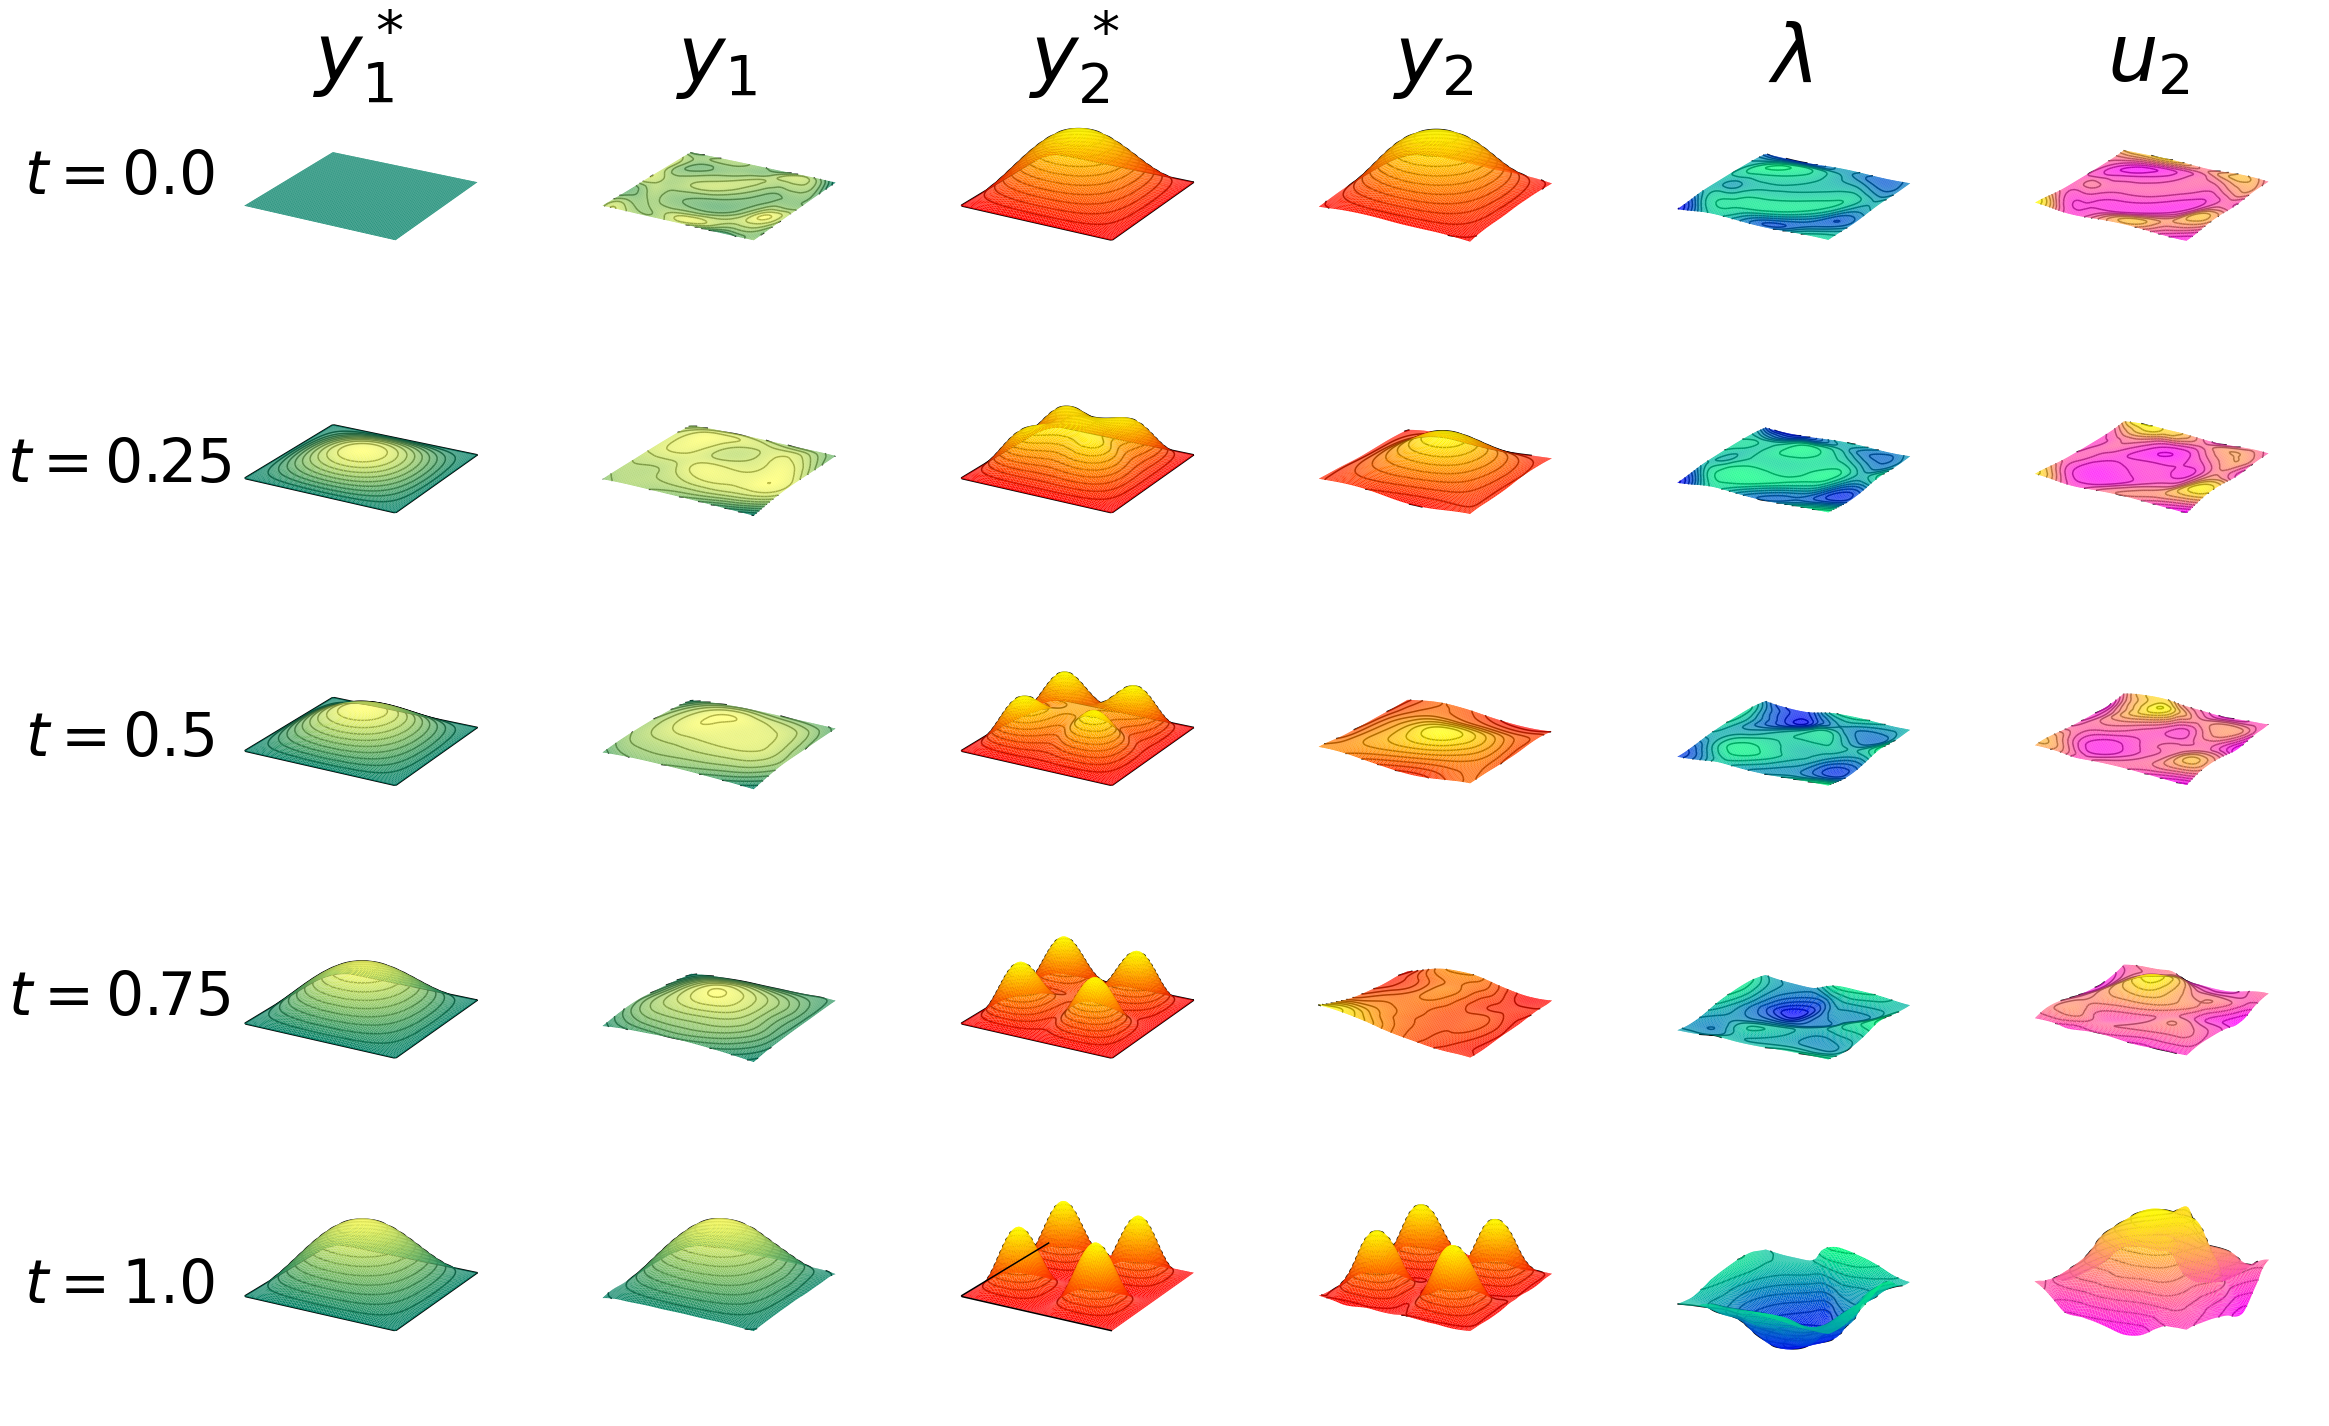

In [ ]:
from matplotlib import cm

num_plot_points = 100
x = np.linspace(0, 1, num_plot_points)
X1_plot, X2_plot = np.meshgrid(x, x)
X1_plot = X1_plot.astype('float32')
X2_plot = X2_plot.astype('float32')

timespans = [0.0, 0.25, 0.5, 0.75, 1.0]
num_time_plots = len(timespans)
titles = ['$y_1^*$', '$y_1$', '$y_2^*$', '$y_2$', '$\lambda$', '$u_2$']

fig = plt.figure(figsize=(30,20))
fig.text(-0.025, .87, '$t=0.0$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .67, '$t=0.25$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .48, '$t=0.5$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .3, '$t=0.75$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .1, '$t=1.0$', ha='center',va='center', size=60)#, rotation='vertical')
j = 0

# Model output: y1, y2, l,  u
for i in range(1,26,6):
  Y1, Y2 = y_ref(timespans[j], X1_plot, X2_plot)
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[j], num_plot_points ** 2)),(-1,1)),
            tf.reshape(tf.constant(X1_plot.flatten()), (-1,1)),
            tf.reshape(tf.constant(X2_plot.flatten()), (-1,1)))

  # Predator Reference
  ax1 = fig.add_subplot(5, 6, i, projection='3d')
  ax1.set_zlim(-1,1)
  if (i < 5):
    ax1.set_title('{}'.format(titles[0]),fontsize=80)
  ax1.plot_surface(X1_plot, X2_plot, Y1, cmap='summer', lw=3, rstride=1, cstride=1)
  ax1.contour(X1_plot, X2_plot, Y1, 10, lw=3, colors='k', linestyles='solid')
  ax1.spines['top'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax1.spines['bottom'].set_visible(False)
  ax1.spines['left'].set_visible(False)
  ax1.axis('off')

  # Predator Prediction
  ax2 = fig.add_subplot(5, 6, i+1, projection='3d')
  ax2.set_yticklabels([])
  ax2.set_xticklabels([])
  ax2.set_zticklabels([])
  ax2.set_zlim(-1,1)
  if (i < 5):
    ax2.set_title('{}'.format(titles[1]),fontsize=80)
  predator_prediction = pred[:,0].numpy().reshape(num_plot_points, num_plot_points)
  ax2.plot_surface(X1_plot, X2_plot, predator_prediction, cmap='summer', lw=3, rstride=1, cstride=1)
  ax2.contour(X1_plot, X2_plot, predator_prediction, 10, lw=3, colors='k', linestyles='solid')
  ax2.spines['top'].set_visible(False)
  ax2.spines['right'].set_visible(False)
  ax2.spines['bottom'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax2.axis('off')

  # Prey Reference
  ax3 = fig.add_subplot(5, 6, i+2, projection='3d')
  ax3.set_yticklabels([])
  ax3.set_xticklabels([])
  ax3.set_zticklabels([])
  ax3.set_zlim(-1,1)
  if (i < 5):
    ax3.set_title('{}'.format(titles[2]),fontsize=80)
  ax3.plot_surface(X1_plot, X2_plot, Y2, cmap='autumn', lw=3, rstride=1, cstride=1)
  ax3.contour(X1_plot, X2_plot, Y2, 10, lw=3, colors='k', linestyles='solid')
  ax3.spines['top'].set_visible(False)
  ax3.spines['right'].set_visible(False)
  ax3.spines['bottom'].set_visible(False)
  ax3.spines['left'].set_visible(False)
  ax3.axis('off')

  # Prey Prediction
  ax4 = fig.add_subplot(5, 6, i+3, projection='3d')
  ax4.set_yticklabels([])
  ax4.set_xticklabels([])
  ax4.set_zticklabels([])
  ax4.set_zlim(-1,1)
  if (i < 5):
    ax4.set_title('{}'.format(titles[3]),fontsize=80)
  prey_prediction = pred[:,1].numpy().reshape(num_plot_points, num_plot_points)
  ax4.plot_surface(X1_plot, X2_plot, prey_prediction, cmap='autumn', lw=3, rstride=1, cstride=1)
  ax4.contour(X1_plot, X2_plot, prey_prediction, 10, lw=3, colors='k', linestyles='solid')
  ax4.spines['top'].set_visible(False)
  ax4.spines['right'].set_visible(False)
  ax4.spines['bottom'].set_visible(False)
  ax4.spines['left'].set_visible(False)
  ax4.axis('off')

  # Lambda
  ax5 = fig.add_subplot(5, 6, i+4, projection='3d')
  ax5.set_yticklabels([])
  ax5.set_xticklabels([])
  ax5.set_zticklabels([])
  ax5.set_zlim(-20,20)
  if (i < 5):
    ax5.set_title('{}'.format(titles[4]),fontsize=80)
  lam = pred[:,2].numpy().reshape(num_plot_points, num_plot_points)
  ax5.plot_surface(X1_plot, X2_plot, lam, cmap='winter', lw=3, rstride=1, cstride=1)
  ax5.contour(X1_plot, X2_plot, lam, 10, lw=3, colors='k', linestyles='solid')
  ax5.spines['top'].set_visible(False)
  ax5.spines['right'].set_visible(False)
  ax5.spines['bottom'].set_visible(False)
  ax5.spines['left'].set_visible(False)
  ax5.axis('off')

  # Control
  ax6 = fig.add_subplot(5, 6, i+5, projection='3d')
  ax6.set_zlim(-20,20)
  if (i < 5):
    ax6.set_title('{}'.format(titles[5]),fontsize=80)
  control = pred[:,3].numpy().reshape(num_plot_points, num_plot_points)
  ax6.plot_surface(X1_plot, X2_plot, control, cmap='spring', lw=3, rstride=1, cstride=1)
  ax6.contour(X1_plot, X2_plot, control, 10, lw=3, colors='k', linestyles='solid')
  ax6.spines['top'].set_visible(False)
  ax6.spines['right'].set_visible(False)
  ax6.spines['bottom'].set_visible(False)
  ax6.spines['left'].set_visible(False)
  ax6.get_xaxis().set_ticks([])
  ax6.get_yaxis().set_ticks([])
  ax6.get_zaxis().set_ticks([])
  ax6.axis('off')

  j += 1

fig.tight_layout()
plt.show()

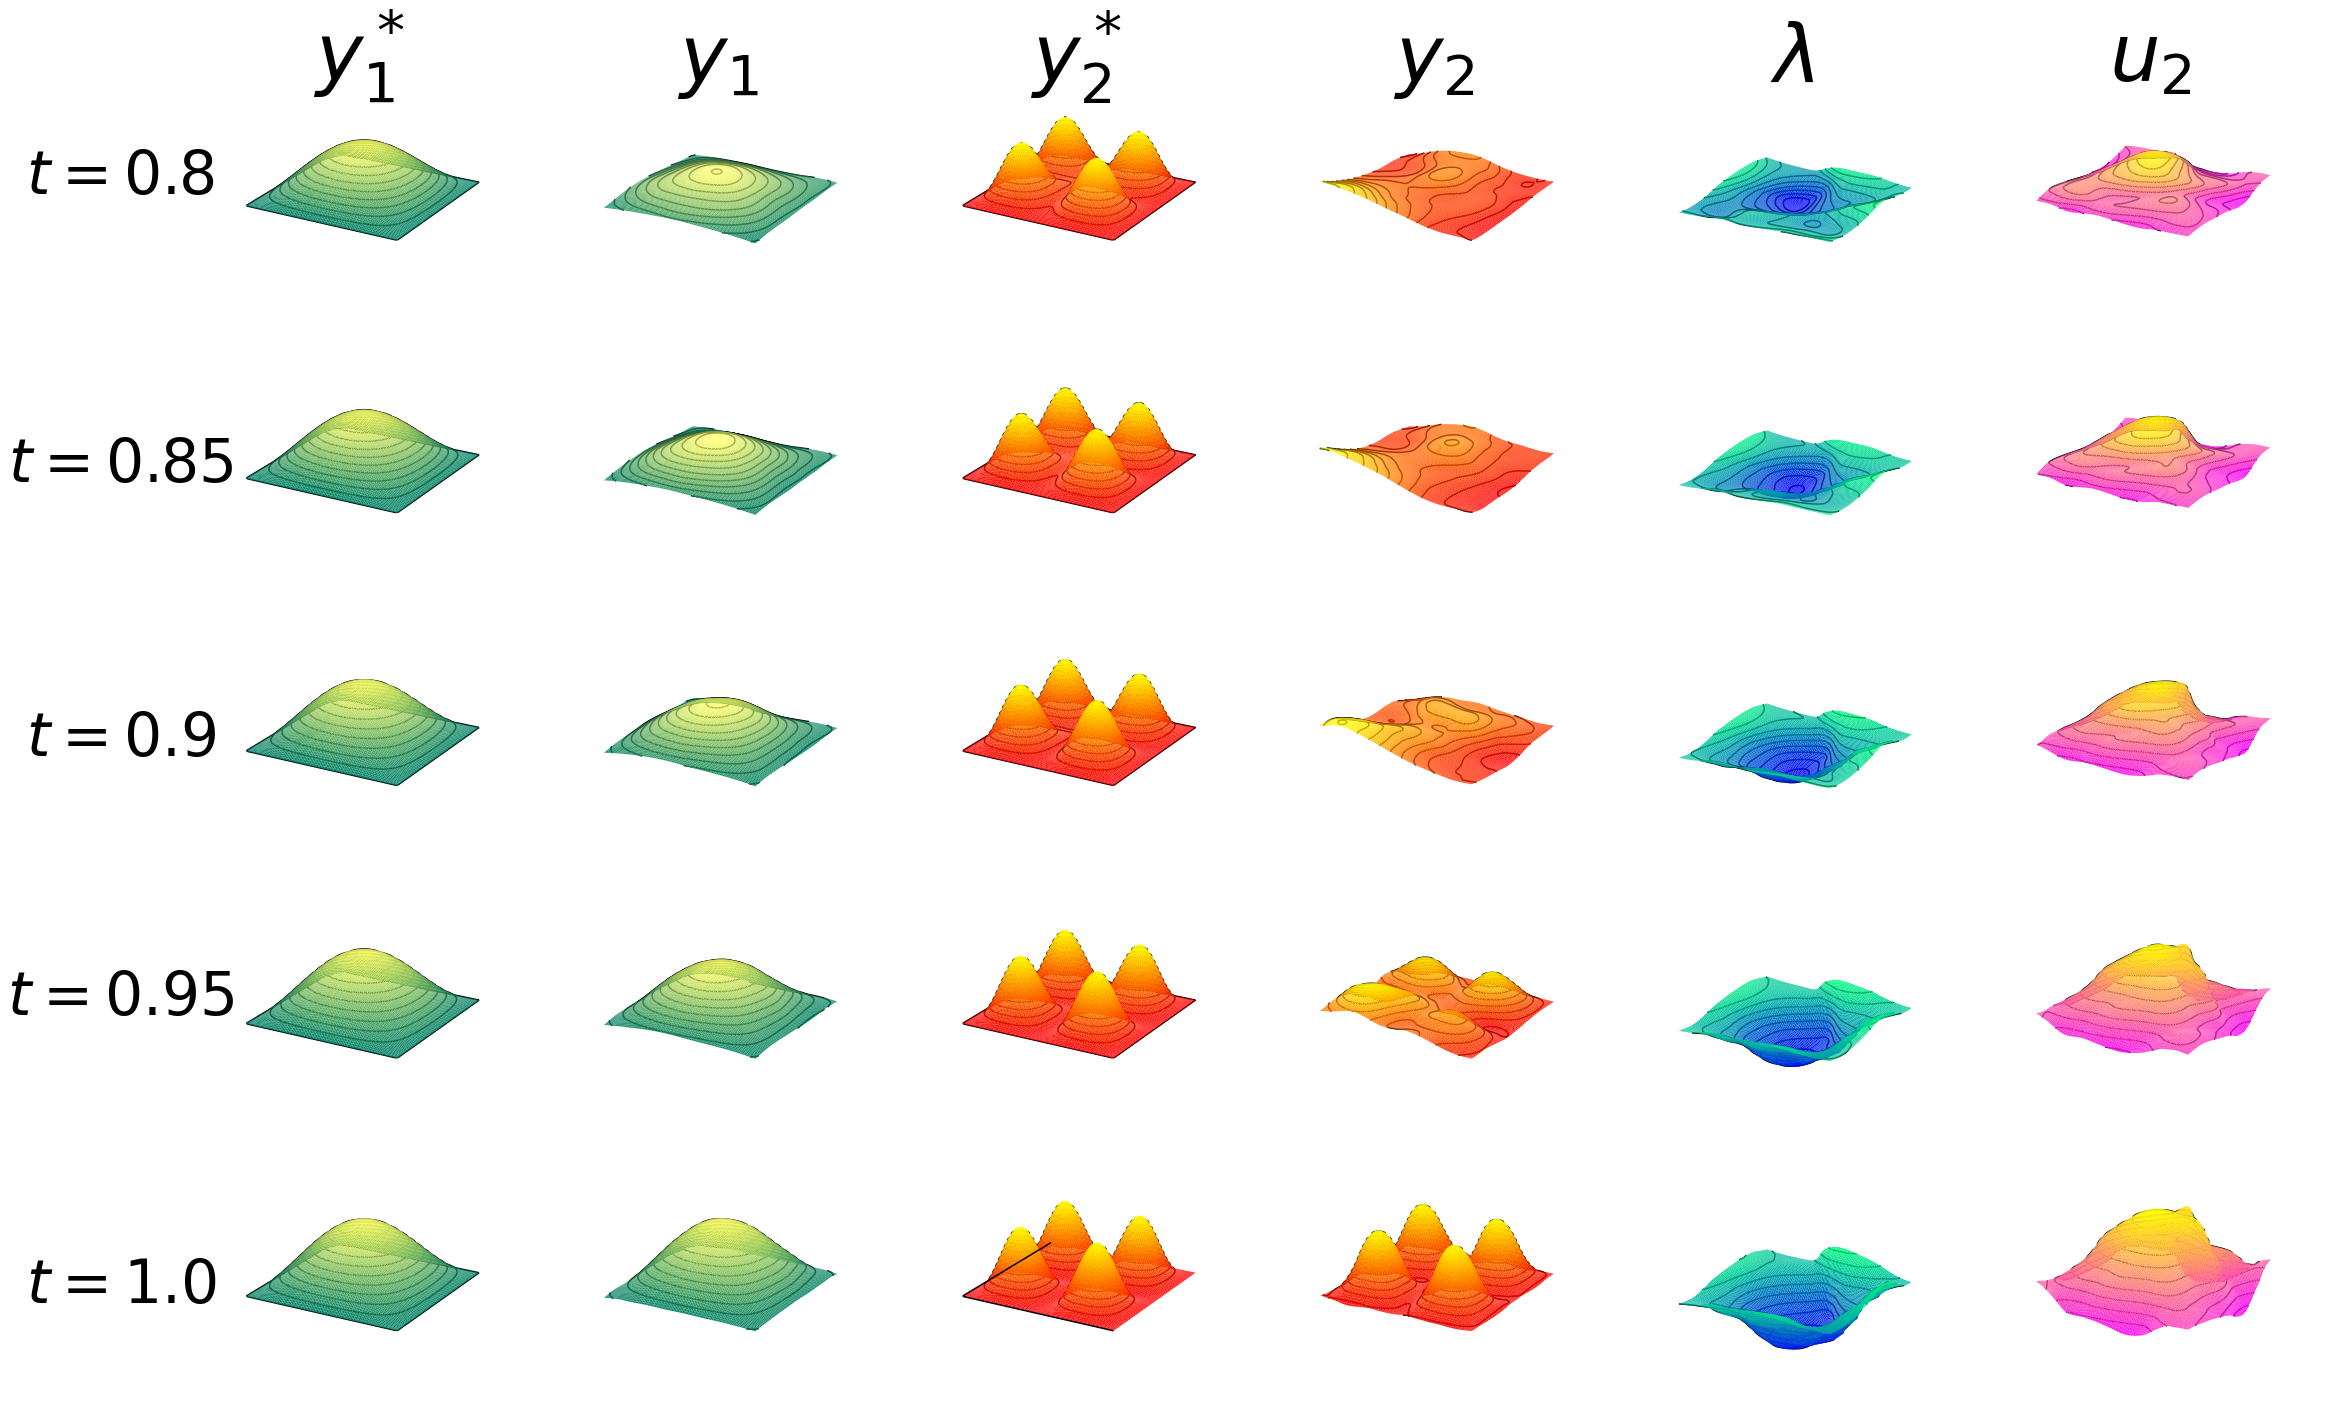

In [ ]:
from matplotlib import cm

num_plot_points = 100
x = np.linspace(0, 1, num_plot_points)
X1_plot, X2_plot = np.meshgrid(x, x)
X1_plot = X1_plot.astype('float32')
X2_plot = X2_plot.astype('float32')

timespans = [0.80, 0.85, 0.90, 0.95, 1.0]
num_time_plots = len(timespans)
titles = ['$y_1^*$', '$y_1$', '$y_2^*$', '$y_2$', '$\lambda$', '$u_2$']

fig = plt.figure(figsize=(30,20))
fig.text(-0.025, .87, '$t=0.8$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .67, '$t=0.85$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .48, '$t=0.9$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .3, '$t=0.95$', ha='center',va='center', size=60)#, rotation='vertical')
fig.text(-0.025, .1, '$t=1.0$', ha='center',va='center', size=60)#, rotation='vertical')
j = 0

# Model output: y1, y2, l,  u
for i in range(1,26,6):
  Y1, Y2 = y_ref(timespans[j], X1_plot, X2_plot)
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[j], num_plot_points ** 2)),(-1,1)),
            tf.reshape(tf.constant(X1_plot.flatten()), (-1,1)),
            tf.reshape(tf.constant(X2_plot.flatten()), (-1,1)))

  # Predator Reference
  ax1 = fig.add_subplot(5, 6, i, projection='3d')
  ax1.set_zlim(-1,1)
  if (i < 5):
    ax1.set_title('{}'.format(titles[0]),fontsize=80)
  ax1.plot_surface(X1_plot, X2_plot, Y1, cmap='summer', lw=3, rstride=1, cstride=1)
  ax1.contour(X1_plot, X2_plot, Y1, 10, lw=3, colors='k', linestyles='solid')
  ax1.spines['top'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax1.spines['bottom'].set_visible(False)
  ax1.spines['left'].set_visible(False)
  ax1.axis('off')

  # Predator Prediction
  ax2 = fig.add_subplot(5, 6, i+1, projection='3d')
  ax2.set_yticklabels([])
  ax2.set_xticklabels([])
  ax2.set_zticklabels([])
  ax2.set_zlim(-1,1)
  if (i < 5):
    ax2.set_title('{}'.format(titles[1]),fontsize=80)
  predator_prediction = pred[:,0].numpy().reshape(num_plot_points, num_plot_points)
  ax2.plot_surface(X1_plot, X2_plot, predator_prediction, cmap='summer', lw=3, rstride=1, cstride=1)
  ax2.contour(X1_plot, X2_plot, predator_prediction, 10, lw=3, colors='k', linestyles='solid')
  ax2.spines['top'].set_visible(False)
  ax2.spines['right'].set_visible(False)
  ax2.spines['bottom'].set_visible(False)
  ax2.spines['left'].set_visible(False)
  ax2.axis('off')

  # Prey Reference
  ax3 = fig.add_subplot(5, 6, i+2, projection='3d')
  ax3.set_yticklabels([])
  ax3.set_xticklabels([])
  ax3.set_zticklabels([])
  ax3.set_zlim(-1,1)
  if (i < 5):
    ax3.set_title('{}'.format(titles[2]),fontsize=80)
  ax3.plot_surface(X1_plot, X2_plot, Y2, cmap='autumn', lw=3, rstride=1, cstride=1)
  ax3.contour(X1_plot, X2_plot, Y2, 10, lw=3, colors='k', linestyles='solid')
  ax3.spines['top'].set_visible(False)
  ax3.spines['right'].set_visible(False)
  ax3.spines['bottom'].set_visible(False)
  ax3.spines['left'].set_visible(False)
  ax3.axis('off')

  # Prey Prediction
  ax4 = fig.add_subplot(5, 6, i+3, projection='3d')
  ax4.set_yticklabels([])
  ax4.set_xticklabels([])
  ax4.set_zticklabels([])
  ax4.set_zlim(-1,1)
  if (i < 5):
    ax4.set_title('{}'.format(titles[3]),fontsize=80)
  prey_prediction = pred[:,1].numpy().reshape(num_plot_points, num_plot_points)
  ax4.plot_surface(X1_plot, X2_plot, prey_prediction, cmap='autumn', lw=3, rstride=1, cstride=1)
  ax4.contour(X1_plot, X2_plot, prey_prediction, 10, lw=3, colors='k', linestyles='solid')
  ax4.spines['top'].set_visible(False)
  ax4.spines['right'].set_visible(False)
  ax4.spines['bottom'].set_visible(False)
  ax4.spines['left'].set_visible(False)
  ax4.axis('off')

  # Lambda
  ax5 = fig.add_subplot(5, 6, i+4, projection='3d')
  ax5.set_yticklabels([])
  ax5.set_xticklabels([])
  ax5.set_zticklabels([])
  ax5.set_zlim(-20,20)
  if (i < 5):
    ax5.set_title('{}'.format(titles[4]),fontsize=80)
  lam = pred[:,2].numpy().reshape(num_plot_points, num_plot_points)
  ax5.plot_surface(X1_plot, X2_plot, lam, cmap='winter', lw=3, rstride=1, cstride=1)
  ax5.contour(X1_plot, X2_plot, lam, 10, lw=3, colors='k', linestyles='solid')
  ax5.spines['top'].set_visible(False)
  ax5.spines['right'].set_visible(False)
  ax5.spines['bottom'].set_visible(False)
  ax5.spines['left'].set_visible(False)
  ax5.axis('off')

  # Control
  ax6 = fig.add_subplot(5, 6, i+5, projection='3d')
  ax6.set_zlim(-20,20)
  if (i < 5):
    ax6.set_title('{}'.format(titles[5]),fontsize=80)
  control = pred[:,3].numpy().reshape(num_plot_points, num_plot_points)
  ax6.plot_surface(X1_plot, X2_plot, control, cmap='spring', lw=3, rstride=1, cstride=1)
  ax6.contour(X1_plot, X2_plot, control, 10, lw=3, colors='k', linestyles='solid')
  ax6.spines['top'].set_visible(False)
  ax6.spines['right'].set_visible(False)
  ax6.spines['bottom'].set_visible(False)
  ax6.spines['left'].set_visible(False)
  ax6.get_xaxis().set_ticks([])
  ax6.get_yaxis().set_ticks([])
  ax6.get_zaxis().set_ticks([])
  ax6.axis('off')

  j += 1

fig.tight_layout()
plt.show()

levels:  [-0.07799695 -0.0240971   0.02980275  0.0837026   0.13760244  0.19150229
  0.24540214  0.29930198  0.35320183  0.40710168  0.46100153  0.51490137
  0.56880122  0.62270107  0.67660092  0.73050076  0.78440061  0.83830046
  0.89220031  0.94610015  1.        ]
vmin:  -0.07799694687128067 vmax:  1.0


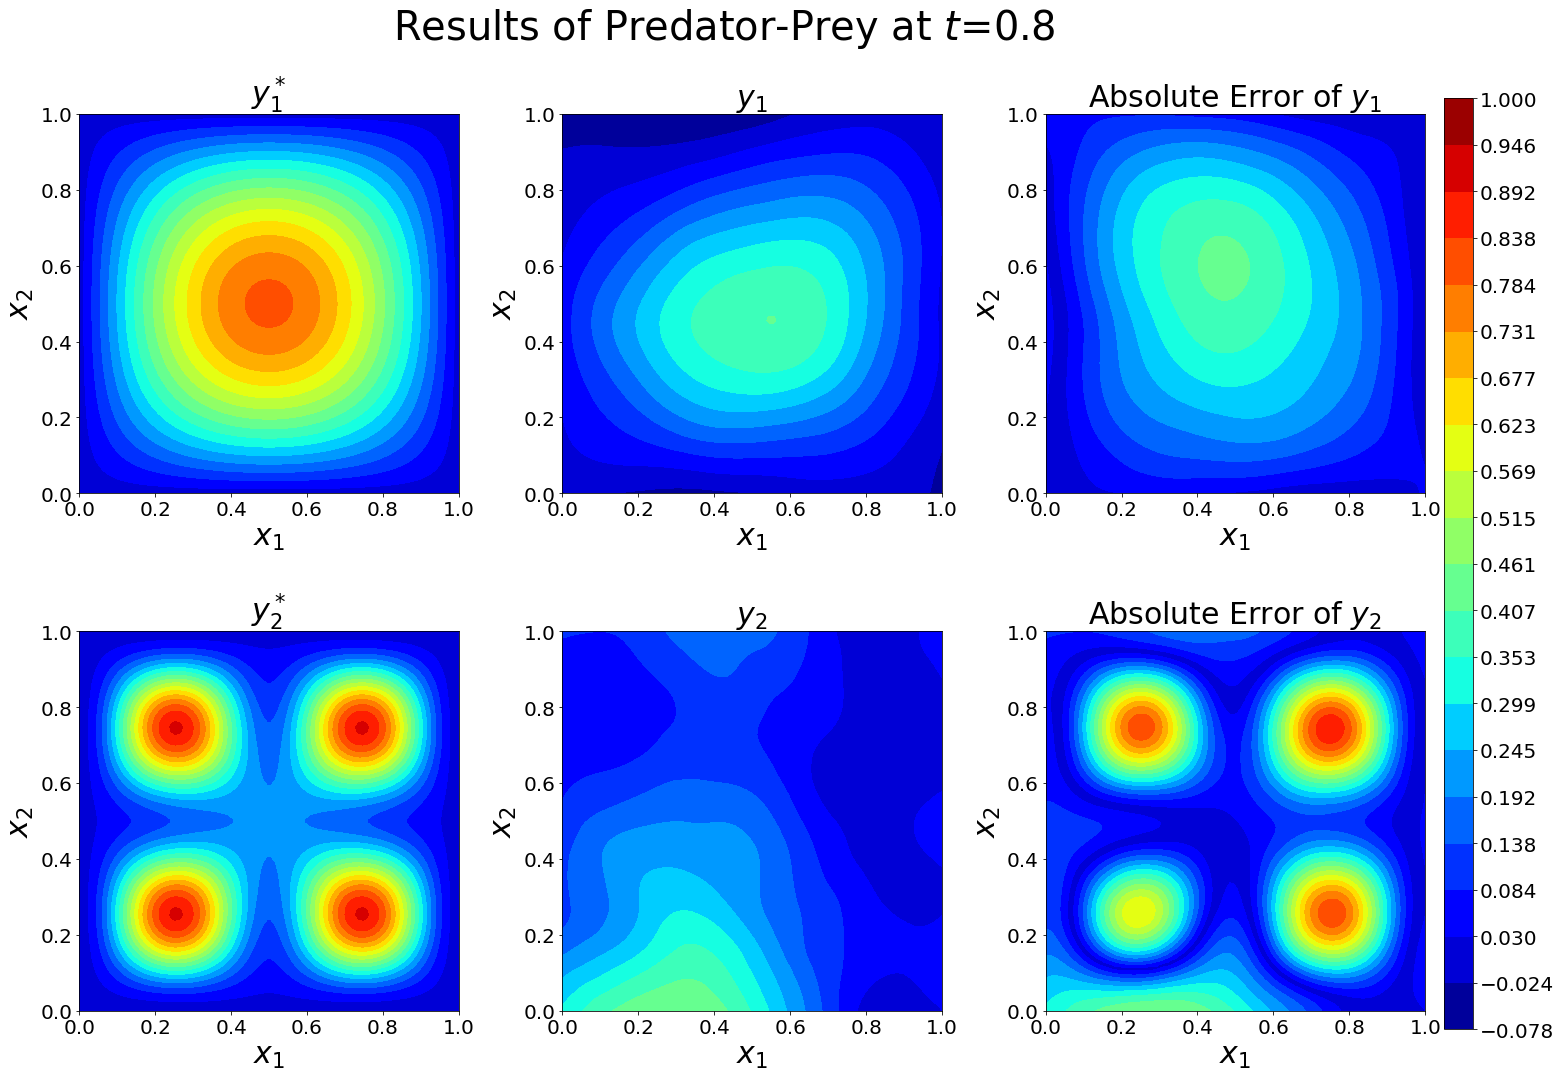

In [118]:
num_plot_points = 100
x = np.linspace(0, 1, num_plot_points)
X1_plot, X2_plot = np.meshgrid(x, x)
X1_plot = X1_plot.astype('float32')
X2_plot = X2_plot.astype('float32')

timespans = [0.80, 0.85, 0.90, 0.95, 1.0]
j = 0
Y1, Y2 = y_ref(timespans[j], X1_plot, X2_plot)
pred = model(tf.reshape(tf.constant(np.repeat(timespans[j], num_plot_points ** 2)),(-1,1)),
          tf.reshape(tf.constant(X1_plot.flatten()), (-1,1)),
          tf.reshape(tf.constant(X2_plot.flatten()), (-1,1)))
predator_prediction = pred[:,0].numpy().reshape(num_plot_points, num_plot_points)
prey_prediction = pred[:,1].numpy().reshape(num_plot_points, num_plot_points)

'''
# Check the max value among exact and predicted results
results = [Y1, Y2, predator_prediction, prey_prediction]
for result in results:
  print(np.min(result))
'''
vmin_overall = np.min([Y1, Y2, predator_prediction, prey_prediction])
vmax_overall = np.max([Y1, Y2, predator_prediction, prey_prediction])

vmin = np.min([0, vmin_overall]) # set to zero or lower if there are negative values
vmax = np.max([1, vmax_overall]) # set to one or higher if there are higher values
levels = np.arange(vmin,vmax + 0.05, (vmax-vmin)/20)
print('levels: ', levels)
print('vmin: ', vmin, 'vmax: ', vmax)

# Absolute Error
error_y1 = np.abs(Y1-predator_prediction)
error_y2 = np.abs(Y2-prey_prediction)

# Make plot
height = 20
width = 15
im_ratio = height / width
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(height, width), constrained_layout=True, facecolor='w', edgecolor='w')
fig.suptitle('Results of Predator-Prey at $t$={}'.format(timespans[j]),fontsize=40)

# y1 star, predator exact
im1 = axes[0,0].contourf(X1_plot, X2_plot, Y1, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[0,0].set_title('$y_1^*$', fontsize=30)
axes[0,0].set_xlabel('$x_1$', fontsize=30)
axes[0,0].set_ylabel('$x_2$', fontsize=30)
axes[0,0].set(adjustable='box', aspect='equal')
axes[0,0].xaxis.set_tick_params(labelsize=20)
axes[0,0].yaxis.set_tick_params(labelsize=20)

# y1, predator prediction
im2 = axes[0,1].contourf(X1_plot, X2_plot, predator_prediction, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[0,1].set_title('$y_1$', fontsize=30)
axes[0,1].set_xlabel('$x_1$', fontsize=30)
axes[0,1].set_ylabel('$x_2$', fontsize=30)
axes[0,1].set(adjustable='box', aspect='equal')
axes[0,1].xaxis.set_tick_params(labelsize=20)
axes[0,1].yaxis.set_tick_params(labelsize=20)

# absolute error between y1* and y1
im3 = axes[0,2].contourf(X1_plot, X2_plot, error_y1, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[0,2].set_title('Absolute Error of $y_1$', fontsize=30)
axes[0,2].set_xlabel('$x_1$', fontsize=30)
axes[0,2].set_ylabel('$x_2$', fontsize=30)
axes[0,2].set(adjustable='box', aspect='equal')
axes[0,2].xaxis.set_tick_params(labelsize=20)
axes[0,2].yaxis.set_tick_params(labelsize=20)

# y2 star, prey exact
im4 = axes[1,0].contourf(X1_plot, X2_plot, Y2, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[1,0].set_title('$y_2^*$', fontsize=30)
axes[1,0].set_xlabel('$x_1$', fontsize=30)
axes[1,0].set_ylabel('$x_2$', fontsize=30)
axes[1,0].set(adjustable='box', aspect='equal')
axes[1,0].xaxis.set_tick_params(labelsize=20)
axes[1,0].yaxis.set_tick_params(labelsize=20)

# y2, prey prediction
im5 = axes[1,1].contourf(X1_plot, X2_plot, prey_prediction, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[1,1].set_title('$y_2$', fontsize=30)
axes[1,1].set_xlabel('$x_1$', fontsize=30)
axes[1,1].set_ylabel('$x_2$', fontsize=30)
axes[1,1].set(adjustable='box', aspect='equal')
axes[1,1].xaxis.set_tick_params(labelsize=20)
axes[1,1].yaxis.set_tick_params(labelsize=20)

# absolute error between y2* and y2
im6 = axes[1,2].contourf(X1_plot, X2_plot, error_y2, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[1,2].set_title('Absolute Error of $y_2$', fontsize=30)
axes[1,2].set_xlabel('$x_1$', fontsize=30)
axes[1,2].set_ylabel('$x_2$', fontsize=30)
axes[1,2].set(adjustable='box', aspect='equal')
axes[1,2].xaxis.set_tick_params(labelsize=20)
axes[1,2].yaxis.set_tick_params(labelsize=20)

cax = fig.add_axes([1, 0.05, 0.02, 0.862])
fig.colorbar(im6, cax=cax, ticks=levels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


levels:  [-0.06915134 -0.01563438  0.03788258  0.09139955  0.14491651  0.19843347
  0.25195044  0.3054674   0.35898436  0.41250133  0.46601829  0.51953525
  0.57305222  0.62656918  0.68008614  0.7336031   0.78712007  0.84063703
  0.89415399  0.94767096  1.00118792]
vmin:  -0.06915134191513062 vmax:  1.0011879205703735


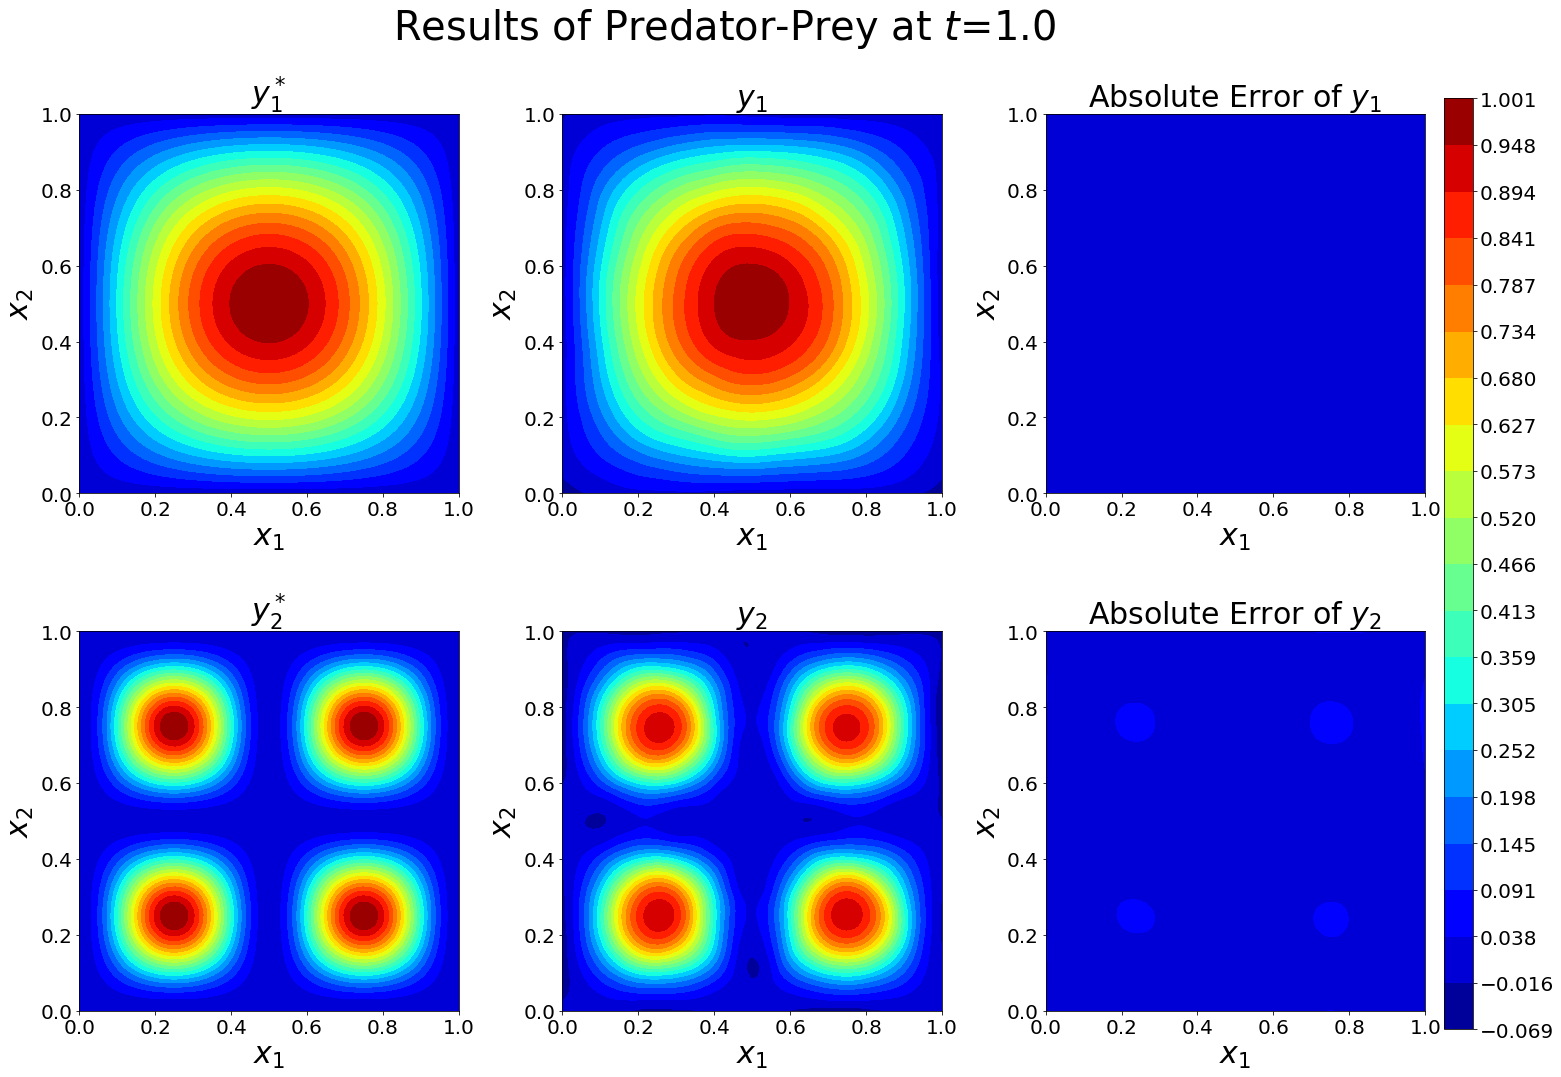

In [117]:
num_plot_points = 100
x = np.linspace(0, 1, num_plot_points)
X1_plot, X2_plot = np.meshgrid(x, x)
X1_plot = X1_plot.astype('float32')
X2_plot = X2_plot.astype('float32')

timespans = [0.80, 0.85, 0.90, 0.95, 1.0]
j = -1
Y1, Y2 = y_ref(timespans[j], X1_plot, X2_plot)
pred = model(tf.reshape(tf.constant(np.repeat(timespans[j], num_plot_points ** 2)),(-1,1)),
          tf.reshape(tf.constant(X1_plot.flatten()), (-1,1)),
          tf.reshape(tf.constant(X2_plot.flatten()), (-1,1)))
predator_prediction = pred[:,0].numpy().reshape(num_plot_points, num_plot_points)
prey_prediction = pred[:,1].numpy().reshape(num_plot_points, num_plot_points)

'''
# Check the max value among exact and predicted results
results = [Y1, Y2, predator_prediction, prey_prediction]
for result in results:
  print(np.min(result))
'''
vmin_overall = np.min([Y1, Y2, predator_prediction, prey_prediction])
vmax_overall = np.max([Y1, Y2, predator_prediction, prey_prediction])

vmin = np.min([0, vmin_overall]) # set to zero or lower if there are negative values
vmax = np.max([1, vmax_overall]) # set to one or higher if there are higher values
levels = np.arange(vmin,vmax + 0.05, (vmax-vmin)/20)
print('levels: ', levels)
print('vmin: ', vmin, 'vmax: ', vmax)

# Absolute Error
error_y1 = np.abs(Y1-predator_prediction)
error_y2 = np.abs(Y2-prey_prediction)

# Make plot
height = 20
width = 15
im_ratio = height / width
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False,figsize=(height, width), constrained_layout=True, facecolor='w', edgecolor='w')
fig.suptitle('Results of Predator-Prey at $t$={}'.format(timespans[j]),fontsize=40)

# y1 star, predator exact
im1 = axes[0,0].contourf(X1_plot, X2_plot, Y1, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[0,0].set_title('$y_1^*$', fontsize=30)
axes[0,0].set_xlabel('$x_1$', fontsize=30)
axes[0,0].set_ylabel('$x_2$', fontsize=30)
axes[0,0].set(adjustable='box', aspect='equal')
axes[0,0].xaxis.set_tick_params(labelsize=20)
axes[0,0].yaxis.set_tick_params(labelsize=20)

# y1, predator prediction
im2 = axes[0,1].contourf(X1_plot, X2_plot, predator_prediction, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[0,1].set_title('$y_1$', fontsize=30)
axes[0,1].set_xlabel('$x_1$', fontsize=30)
axes[0,1].set_ylabel('$x_2$', fontsize=30)
axes[0,1].set(adjustable='box', aspect='equal')
axes[0,1].xaxis.set_tick_params(labelsize=20)
axes[0,1].yaxis.set_tick_params(labelsize=20)

# absolute error between y1* and y1
im3 = axes[0,2].contourf(X1_plot, X2_plot, error_y1, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[0,2].set_title('Absolute Error of $y_1$', fontsize=30)
axes[0,2].set_xlabel('$x_1$', fontsize=30)
axes[0,2].set_ylabel('$x_2$', fontsize=30)
axes[0,2].set(adjustable='box', aspect='equal')
axes[0,2].xaxis.set_tick_params(labelsize=20)
axes[0,2].yaxis.set_tick_params(labelsize=20)

# y2 star, prey exact
im4 = axes[1,0].contourf(X1_plot, X2_plot, Y2, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[1,0].set_title('$y_2^*$', fontsize=30)
axes[1,0].set_xlabel('$x_1$', fontsize=30)
axes[1,0].set_ylabel('$x_2$', fontsize=30)
axes[1,0].set(adjustable='box', aspect='equal')
axes[1,0].xaxis.set_tick_params(labelsize=20)
axes[1,0].yaxis.set_tick_params(labelsize=20)

# y2, prey prediction
im5 = axes[1,1].contourf(X1_plot, X2_plot, prey_prediction, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[1,1].set_title('$y_2$', fontsize=30)
axes[1,1].set_xlabel('$x_1$', fontsize=30)
axes[1,1].set_ylabel('$x_2$', fontsize=30)
axes[1,1].set(adjustable='box', aspect='equal')
axes[1,1].xaxis.set_tick_params(labelsize=20)
axes[1,1].yaxis.set_tick_params(labelsize=20)

# absolute error between y2* and y2
im6 = axes[1,2].contourf(X1_plot, X2_plot, error_y2, cmap='jet', vmin=vmin, vmax=vmax, levels=levels)
axes[1,2].set_title('Absolute Error of $y_2$', fontsize=30)
axes[1,2].set_xlabel('$x_1$', fontsize=30)
axes[1,2].set_ylabel('$x_2$', fontsize=30)
axes[1,2].set(adjustable='box', aspect='equal')
axes[1,2].xaxis.set_tick_params(labelsize=20)
axes[1,2].yaxis.set_tick_params(labelsize=20)

cax = fig.add_axes([1, 0.05, 0.02, 0.862])
fig.colorbar(im6, cax=cax, ticks=levels)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
